## 3. Part 2 - House prices

In this second part, you will work on the house prices data set assembled and published by Dean De Cock. It's a set of 2,930 observations with 82 attributes each. The goal is to use the first 2,430 ones to fit and evaluate different models and use them to make predictions for the last 500 ones. Note that we don't provide the prices for those 500 houses, your task is to estimate them.

### Project files

Download the $house-prices.zip$ archive from the resource section. You should see the following files

* Detailed data description - documentation.txt
* The 2,430 data points with prices - house-prices.csv
* The remaining 500 without prices - house-prices-test.csv
* Example submission file - predictions-example.csv
* Data set source - source.txt

Create a $house-prices-solution.ipynb$ notebook to write your analysis. The notebook should also run with the $exts-ml$ environment.

### A quick look at the data

Here are the first five entries from $house-prices.csv$

https://d7whxh71cqykp.cloudfront.net/uploads/image/data/3784/houses-df.png

You can find a detailed description of each variable in the $documentation.txt$ file, but there are a few things to know.

* The $Order$ and PID variables are identifiers. They are not useful to predict house prices.
* The variables are not necessarily encoded consistently. For instance, MS SubClass (the type of dwelling) and MS Zoning (zoning classification) are both categorical variables, but one is encoded with numerical values and the other with short labels.
* The data isn't clean: there are incorrect and missing values, outliers and inconsistencies

You should address all these issues during the **data cleaning** stage.

### Data cleaning

Your analysis should include the necessary **data cleaning steps**. For instance

* Find and handle incorrect, missing values
* Correct inconsistencies in the variables
* Handle outliers

You are free to choose your preferred approach to handle each step. For instance, you might want to replace missing values with the average or the most frequent value or create an missing category. In any case, **justify your choices!**

### Feature encoding

Your analysis should include the necessary **feature encoding steps**. The $documentation.txt$ file labels each variable with its type. For categorical ones, it uses the ordinal, nominal and discrete classification.

* Ordinal variables - you can order the categories
* Nominal variables - no possible ordering
* Discrete variables - categories are integer values

The encoding depends on the type of variable and its meaning. For instance, the kitchen quality variable is on a scale from excellent to poor. Hence, it's an ordinal variable, and you can choose to apply one-hot encoding or define a numerical scale ex. excellent corresponds to 5 and poor to 1. In any case, **justify your choices**!

### Feature engineering

Your analysis should also include **feature engineering**. Here are a few ideas

* Create indicator variables ex. year of construction is older than some threshold
* Transformations ex. log-transforms, polynomials

Suggestion: write down your feature engineering ideas during the data exploration stage.

*Warning: Be careful when adding total counts (ex. the total number of rooms, living surface) and other linear combinations of the input features. Those variables don't add "modeling power" to the model if you keep the original features in the data and can lead to ill-conditioning and numerical issues. On the other hand, if you create such variables and remove the original features, it can be seen as a way to compress the information on fewer dimensions which can be useful for the simple and intermediate models where the number of variables is limited.*

### Model fitting

Your analysis should include an appropriate **baseline** and evaluate three different models ranging in complexity

* A **simple model** with two variables (three with the target variable)
* An **intermediate model** (between 10 and 20 variables)
* A **complex model** with all variables

The number of variables is only given as an indication, it's not a strict range. Also, it corresponds to the variables count before one-hot encoding. For the simple and intermediate models, you can choose the variables. You are free to choose your preferred approach for this variable selection step, but you should include a short comment to **explain your choice**.

*Example: I decide to choose variables v1, v2 and v3 for my simple model because I think that they provide a good overview of the house - or - I choose these variables because they are the most correlated with the target - or - I decide to test the SelectKBest object that I found in Scikit-learn to do automatic feature selection.*

### Regularization

Your analysis should include **regularization** for at least the complex model, tune its strength with **grid search** and plot the **validation curves.**

### Communicating the results

You are free to use any appropriate cost function to fit your models, with or without prices transformation ex. log-transformed. You can also choose the train/test split ratio ex. 50-50 split. However, **explain your choices** in the notebook.

You can also track different metrics to evaluate the performance of your models. However, make sure to print the **mean absolute error** (MAE) score **in dollars** for each one.

*Example: My simple model has an MAE of 25,123 thousand dollars - or - The mean MAE score of my model is .. ± .. dollars (std)*

Your analysis should also include a final visualization which summarizes the different models MAE scores. For instance, using a bar chart

https://d7whxh71cqykp.cloudfront.net/uploads/image/data/3785/bar-chart.svg

or even a box-plot if you decided to evaluate your models on several train/test splits

https://d7whxh71cqykp.cloudfront.net/uploads/image/data/3786/box-plot.svg

### Compute predictions

Make predictions for the 500 new houses from $house-prices-test.csv$ using each model and save them in a $.csv$ file.

* Predictions from your simple model - predictions-simple-model.csv
* Predictions from your intermediate model - predictions-intermediate-model.csv
* Predictions from your complex model - predictions-complex-model.csv

Your .csv files should contain two columns: the house PID and the predicted price. You can find a sample submission file in $predictions-example.csv$. 
<br>**Note**: The numbers in this example file are arbitrary and do not have any characteristics or relationships to the true values of the prediction set.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv(r'house-price\house-prices.csv')
data_test = pd.read_csv(r'house-price\house-prices-test.csv')
print('Data shape:',data.shape)
print('Data test shape:',data_test.shape)

Data shape: (2430, 82)
Data test shape: (500, 81)


## (A) Data cleaning

In [3]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Order,2430.0,1.469478e+03,8.432365e+02,1.0,7.492500e+02,1470.5,2.193500e+03,2.930000e+03
PID,2430.0,7.149375e+08,1.887339e+08,526301100.0,5.284770e+08,535454055.0,9.071352e+08,1.007100e+09
MS SubClass,2430.0,5.709259e+01,4.290325e+01,20.0,2.000000e+01,50.0,7.000000e+01,1.900000e+02
Lot Frontage,2010.0,6.920199e+01,2.348699e+01,21.0,5.800000e+01,68.0,8.000000e+01,3.130000e+02
Lot Area,2430.0,1.024356e+04,8.353925e+03,1470.0,7.482000e+03,9500.0,1.160450e+04,2.152450e+05
Overall Qual,2430.0,6.088889e+00,1.414621e+00,1.0,5.000000e+00,6.0,7.000000e+00,1.000000e+01
Overall Cond,2430.0,5.569959e+00,1.116442e+00,1.0,5.000000e+00,5.0,6.000000e+00,9.000000e+00
Year Built,2430.0,1.971167e+03,3.020793e+01,1875.0,1.954000e+03,1973.0,2.000000e+03,2.010000e+03
Year Remod/Add,2430.0,1.984239e+03,2.075116e+01,1950.0,1.966000e+03,1993.0,2.003000e+03,2.010000e+03
Mas Vnr Area,2410.0,1.019954e+02,1.766117e+02,0.0,0.000000e+00,0.0,1.647500e+02,1.600000e+03


In [4]:
data.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

### MS SubClass (Nominal) - clean

In [5]:
# Don't seem to be any issue with this variable but will need to use one-hot encoding [Nominal]
data['MS SubClass'].unique()

array([ 60,  20, 160, 190,  50,  70, 120,  30,  90,  85,  45,  80, 180,
        75,  40, 150], dtype=int64)

In [6]:
data_test['MS SubClass'].unique()

array([ 50,  20,  60,  30,  80, 160,  90, 120,  70, 180, 190,  75,  45,
        85,  40], dtype=int64)

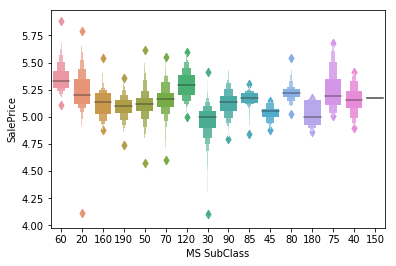

In [7]:
import seaborn as sns
c = 'MS SubClass'
sns.boxenplot(data[c],np.log10(data['SalePrice']),order=data[c].unique());

In [8]:
# both points below 4.24 seems to be outliers in their categories and therefore suggesting to tag as outliers
data[np.log10(data['SalePrice']) < 4.25][['SalePrice','MS SubClass']]

,SalePrice,MS SubClass
491,13100,20
1757,12789,30


In [9]:
outlier = np.log10(data['SalePrice']) < 4.25
outlier.sum()

2

### MS Zoning (Nominal) - clean

In [10]:
# Don't seem to be any issue with this variable but will need to use one-hot-encoding [Nominal]
data['MS Zoning'].unique()

array(['RL', 'RM', 'FV', 'I (all)', 'C (all)', 'RH', 'A (agr)'],
      dtype=object)

In [11]:
data_test['MS Zoning'].unique()

array(['RL', 'C (all)', 'FV', 'RH', 'RM'], dtype=object)

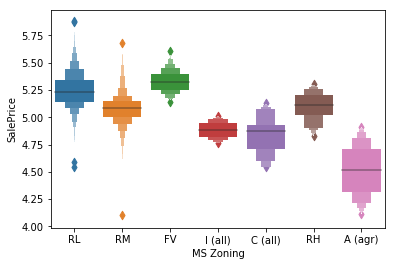

In [12]:
c = 'MS Zoning'
sns.boxenplot(data[c],np.log10(data['SalePrice']),order=data[c].unique());

In [13]:
# consider lower point in 'RM' as outlier
data[(np.log10(data['SalePrice']) < 4.25) & (data['MS Zoning'] == 'RM')][['SalePrice','MS Zoning']]

,SalePrice,MS Zoning
1757,12789,RM


In [14]:
print('Outliers pre:',outlier.sum())
outlier = ((np.log10(data['SalePrice']) < 4.25) & (data['MS Zoning'] == 'RM')) | outlier
print('Outliers post:',outlier.sum())

Outliers pre: 2
Outliers post: 2


### Lot Frontage (Continous) - fill na & handle outliers

C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


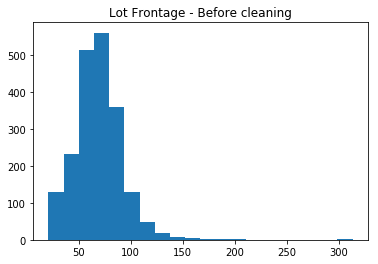

In [15]:
plt.hist(data['Lot Frontage'],bins=20)
#plt.scatter(data['Lot Frontage'], data['SalePrice'])
plt.title('Lot Frontage - Before cleaning')
plt.show()

In [16]:
# Decision to handle outliers before handling NA. This would avoid impacting mean and std
# In fact above comment wouldn't impact as I decided to consier outliers above 250 $ instead of using z-score which would have been impacted but lower boundary at 0

#data[(np.abs((data['Lot Frontage']- data['Lot Frontage'].mean()) / data['Lot Frontage'].std()) > 5)]['Lot Frontage']
#(np.abs((data['Lot Frontage']- data['Lot Frontage'].mean()) / data['Lot Frontage'].std()) > 2).sum()

print('Outliers pre:',outlier.sum())
outlier = (data['Lot Frontage'] > 250) | outlier
print('Outliers post:',outlier.sum())

Outliers pre: 2
Outliers post: 4


In [17]:
print('Count NA values:',data['Lot Frontage'].isnull().sum())
print('Median value {:.0f}'.format(data['Lot Frontage'].median()))

Count NA values: 420
Median value 68


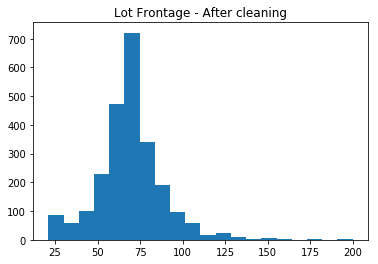

In [18]:
# replace NA values with median
data['Lot Frontage'].fillna(value=data['Lot Frontage'].median(),inplace=True)
plt.hist(data[~outlier]['Lot Frontage'],bins=20)
plt.title('Lot Frontage - After cleaning')
plt.show()

In [19]:
# handle test data
print(data_test['Lot Frontage'].isnull().sum())
data_test['Lot Frontage'].fillna(value=data['Lot Frontage'].median(),inplace=True)

70


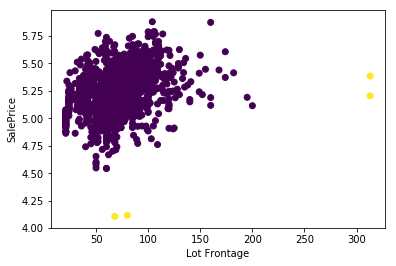

In [20]:
x = 'Lot Frontage'
y = 'SalePrice'
plt.scatter(data[x], np.log10(data[y]), c=outlier)
plt.xlabel(x)
plt.ylabel(y)
plt.show()

### Lot Area (Continuous) - handle outliers

In [21]:
# No NA values
data['Lot Area'].isnull().sum()

0

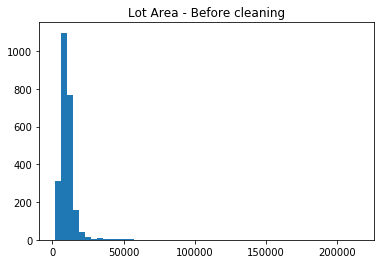

In [22]:
plt.hist(data['Lot Area'], bins=50)
plt.title('Lot Area - Before cleaning')
plt.show()

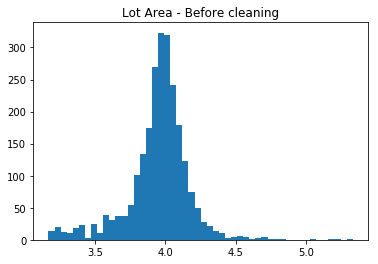

In [23]:
plt.hist(np.log10(data['Lot Area']), bins=50)
plt.title('Lot Area - Before cleaning')
plt.show()

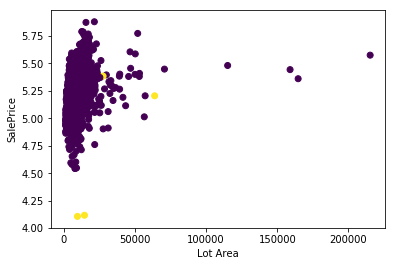

In [24]:
x = 'Lot Area'
y = 'SalePrice'
plt.scatter(data[x], np.log10(data[y]), c=outlier)
plt.xlabel(x)
plt.ylabel(y)
plt.show()

In [25]:
data[data['Lot Area'] > 60000]['Lot Area']

267     164660
685      70761
1500     63887
1513    159000
2257    215245
2316    115149
Name: Lot Area, dtype: int64

In [26]:
# Decided to tag as outliers 'Lot Area' above 50k based on both scatter plot and histogram without log transoformation
print('Outliers pre:',outlier.sum())
outlier = (data['Lot Area'] > 60000) | outlier
print('Outliers post:',outlier.sum())

Outliers pre: 4
Outliers post: 9


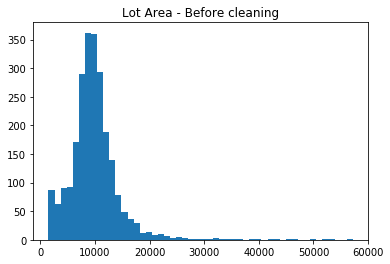

In [27]:
plt.hist(data[~outlier]['Lot Area'], bins=50)
plt.title('Lot Area - Before cleaning')
plt.show()

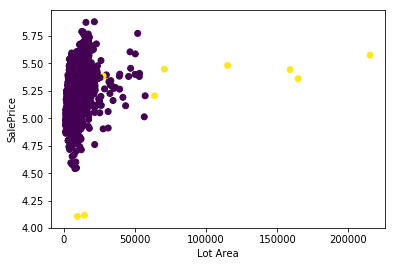

In [28]:
x = 'Lot Area'
y = 'SalePrice'
plt.scatter(data[x], np.log10(data[y]), c=outlier)
plt.xlabel(x)
plt.ylabel(y)
plt.show()

In [29]:
# handle test data
data_test['Lot Area'].isnull().sum()

0

### Street (Nominal) - clean

In [30]:
data['Street'].unique()

array(['Pave', 'Grvl'], dtype=object)

In [31]:
# handle test data
data_test['Street'].unique()

array(['Pave', 'Grvl'], dtype=object)

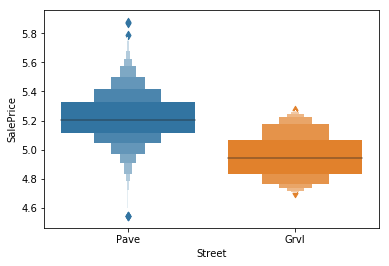

In [32]:
c = 'Street'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']),order=data[c].unique());

### Alley (Nominal) - fill na

In [33]:
data['Alley'].unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

In [34]:
# large number of 'No access'
data['Alley'].fillna(value='No access',inplace=True)
data[['Alley','Order']].groupby('Alley').count()

,Order
Alley,
Grvl,104
No access,2267
Pave,59


In [35]:
# handle test data
data_test['Alley'].unique()

array([nan, 'Pave', 'Grvl'], dtype=object)

In [36]:
# large number of 'No access'
data_test['Alley'].fillna(value='No access',inplace=True)
data_test[['Alley','Order']].groupby('Alley').count()

,Order
Alley,
Grvl,16
No access,465
Pave,19


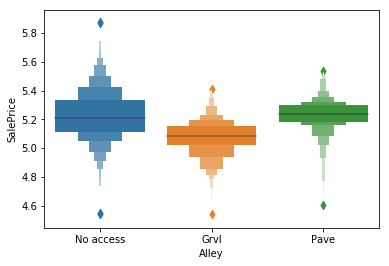

In [37]:
c = 'Alley'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']),order=data[c].unique());

### Lot Shape (Ordinal) - Regroup categories

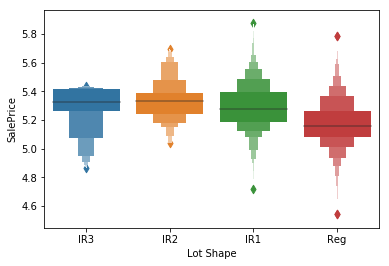

In [38]:
c = 'Lot Shape'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']),order=['IR3','IR2','IR1','Reg']);

In [39]:
data['Lot Shape'].unique()

array(['IR1', 'Reg', 'IR2', 'IR3'], dtype=object)

In [40]:
# SalePrice difference seems to be mostly between Regular vs Irregular (no matter which category). Therefore decide to regrou pirregulars together
data[['Lot Shape','SalePrice']].groupby('Lot Shape').mean()

,SalePrice
Lot Shape,
IR1,210918.299043
IR2,227798.257576
IR3,211418.928571
Reg,160873.847424


In [41]:
# Update for both train and test set
data['Lot Shape'].replace({'IR1': 'IR','IR2': 'IR','IR3': 'IR'},inplace=True)
data_test['Lot Shape'].replace({'IR1': 'IR','IR2': 'IR','IR3': 'IR'},inplace=True)

### Land Contour (Nominal) - clean

In [42]:
data['Land Contour'].unique()

array(['Lvl', 'Bnk', 'HLS', 'Low'], dtype=object)

In [43]:
# handle test data
data_test['Land Contour'].unique()

array(['HLS', 'Low', 'Lvl', 'Bnk'], dtype=object)

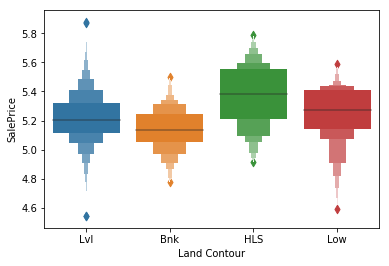

In [44]:
c = 'Land Contour'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']),order=data[c].unique());

### Utilities (Ordinal) - convert to numerical scale

In [45]:
# No ELO values
data['Utilities'].unique()

array(['AllPub', 'NoSewr', 'NoSeWa'], dtype=object)

In [46]:
# Decide to convert to numerical based on number of utility type available
# Update for both train and test set
data['Utilities'].replace({'AllPub': 5,'NoSewr': 3,'NoSeWa': 2,'ELO':1},inplace=True)
data_test['Utilities'].replace({'AllPub': 5,'NoSewr': 3,'NoSeWa': 2,'ELO':1},inplace=True)

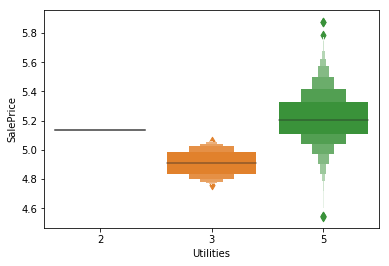

In [47]:
c = 'Utilities'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Lot Config (Nominal) - clean

In [48]:
data['Lot Config'].unique()

array(['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3'], dtype=object)

In [49]:
# handle test data
data_test['Lot Config'].unique()

array(['Corner', 'Inside', 'CulDSac', 'FR2', 'FR3'], dtype=object)

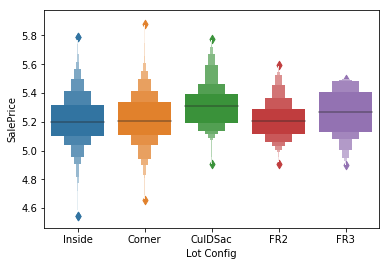

In [50]:
c = 'Lot Config'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']),order=data[c].unique());

### Land Slope (Ordinal) - clean

In [51]:
data['Land Slope'].unique()

array(['Gtl', 'Mod', 'Sev'], dtype=object)

In [52]:
# Very low number of Mod and Sev. Decide to keep as it is
data[['Land Slope','Order']].groupby('Land Slope').agg({'Order':{'Count':'count','Mean':'mean'}})

C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\pandas\core\groupby\generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Order             
           Count         Mean
Land Slope                   
Gtl         2312  1465.721021
Mod          102  1549.401961
Sev           16  1502.875000

In [53]:
# handle test data
data_test['Land Slope'].unique()

array(['Mod', 'Gtl'], dtype=object)

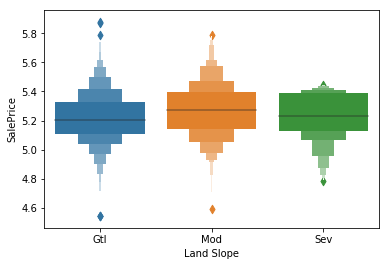

In [54]:
c = 'Land Slope'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']),order=data[c].unique());

### Neighbordhood (Nominal) - clean

In [55]:
data['Neighborhood'].unique()

array(['Gilbert', 'NAmes', 'MeadowV', 'OldTown', 'SawyerW', 'Somerst',
       'Timber', 'Edwards', 'NWAmes', 'Mitchel', 'CollgCr', 'NridgHt',
       'IDOTRR', 'NoRidge', 'GrnHill', 'Crawfor', 'StoneBr', 'BrDale',
       'BrkSide', 'Landmrk', 'SWISU', 'Sawyer', 'ClearCr', 'Greens',
       'Veenker', 'Blueste', 'NPkVill', 'Blmngtn'], dtype=object)

In [56]:
# handle test data
data_test['Neighborhood'].unique()

array(['Crawfor', 'CollgCr', 'NridgHt', 'NAmes', 'IDOTRR', 'SawyerW',
       'Edwards', 'Timber', 'SWISU', 'Somerst', 'Gilbert', 'NoRidge',
       'NWAmes', 'Sawyer', 'Blmngtn', 'OldTown', 'Mitchel', 'BrkSide',
       'ClearCr', 'MeadowV', 'Blueste', 'NPkVill', 'BrDale', 'StoneBr',
       'Veenker'], dtype=object)

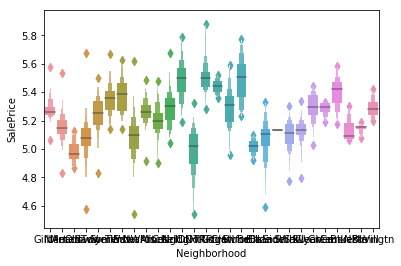

In [57]:
c = 'Neighborhood'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']),order=data[c].unique());
# too granular to be able to call-out outliers

### Condition 1 & 2 (Nominal) - Clean

In [58]:
data['Condition 1'].unique()

array(['Norm', 'Feedr', 'PosN', 'RRAe', 'Artery', 'PosA', 'RRAn', 'RRNn',
       'RRNe'], dtype=object)

In [59]:
data['Condition 2'].unique()

array(['Norm', 'PosA', 'Feedr', 'Artery', 'RRNn', 'PosN', 'RRAe', 'RRAn'],
      dtype=object)

In [60]:
# handle test data
data_test['Condition 1'].unique()

array(['Norm', 'Feedr', 'Artery', 'RRAn', 'RRNe', 'PosN', 'RRNn', 'RRAe',
       'PosA'], dtype=object)

In [61]:
# handle test data
data_test['Condition 2'].unique()

array(['Norm', 'PosN', 'Feedr'], dtype=object)

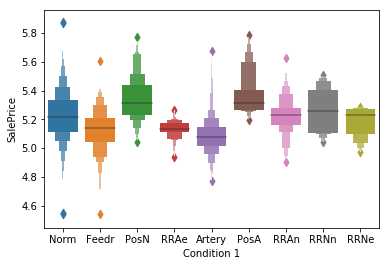

In [62]:
c = 'Condition 1'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']),order=data[c].unique());

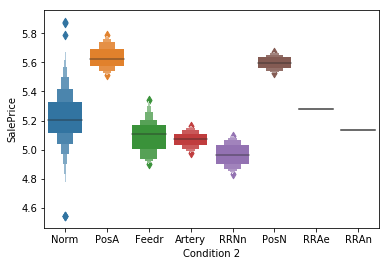

In [63]:
c = 'Condition 2'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']),order=data[c].unique());

### Bldg Type (Nominal) - clean

In [64]:
data['Bldg Type'].unique()

array(['1Fam', 'Twnhs', '2fmCon', 'TwnhsE', 'Duplex'], dtype=object)

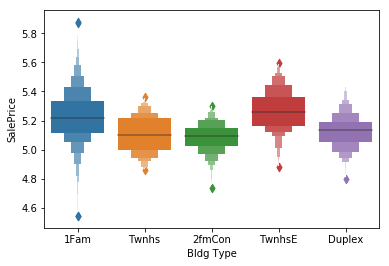

In [65]:
c = 'Bldg Type'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']),order=data[c].unique());

### House Style (Nominal) - clean

In [66]:
data['House Style'].unique()

array(['2Story', '1Story', '2.5Unf', '1.5Fin', 'SFoyer', '1.5Unf', 'SLvl',
       '2.5Fin'], dtype=object)

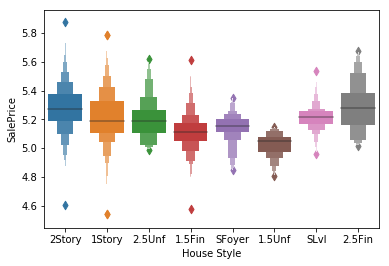

In [67]:
c = 'House Style'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']),order=data[c].unique());

### Overall Qual & Overall Cond (Ordinal) - clean

In [68]:
data['Overall Qual'].unique()

array([ 7,  6,  4,  5,  8,  9, 10,  3,  1,  2], dtype=int64)

In [69]:
data['Overall Cond'].unique()

array([5, 6, 4, 8, 7, 1, 9, 3, 2], dtype=int64)

In [70]:
data['Overall Qual'].isnull().sum()

0

In [71]:
data['Overall Cond'].isnull().sum()

0

In [72]:
# handle test data
print(data_test['Overall Qual'].isnull().sum())
print(data_test['Overall Cond'].isnull().sum())

0
0


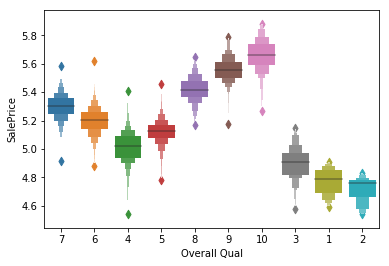

In [73]:
c = 'Overall Qual'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']),order=data[c].unique());

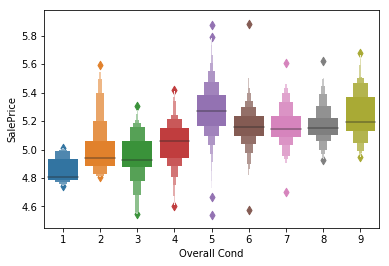

In [74]:
c = 'Overall Cond'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Year Built (Discrete) - clean (potential of bucketing)

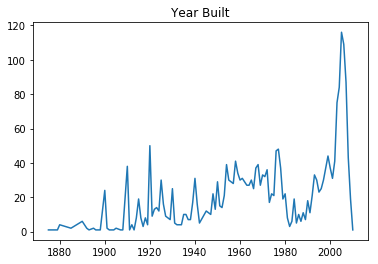

In [75]:
plt.plot(data[['Year Built','Order']].groupby('Year Built').count())
plt.title('Year Built')
plt.show()

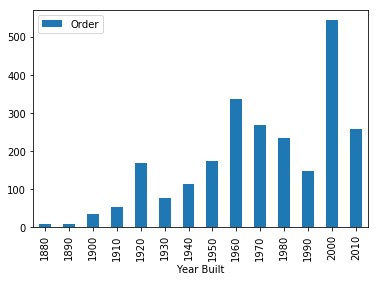

In [76]:
data['Year Built'] = round(data['Year Built'],-1)
data[['Year Built','Order']].groupby('Year Built').count().plot(kind='bar')
plt.show()

In [77]:
# handle test data
data_test['Year Built'] = round(data_test['Year Built'],-1)

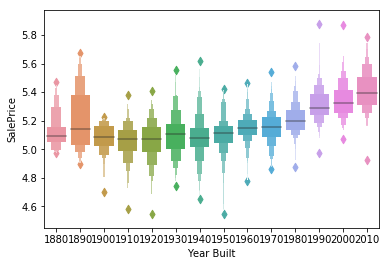

In [78]:
c = 'Year Built'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Year Remod/Add (Discrete) - handle value stuck on 1950

Count Nan: 0


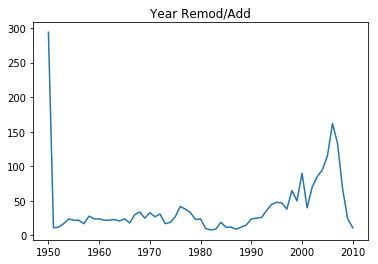

In [79]:
# seems strange that we have that many data around 1950 ond not data before
# Suggest to make some adjustements where 'Year Built' is 
print('Count Nan:',data['Year Remod/Add'].isnull().sum())
plt.plot(data[['Year Remod/Add','Order']].groupby('Year Remod/Add').count())
plt.title('Year Remod/Add')
plt.show()

Count values on 1950: 294


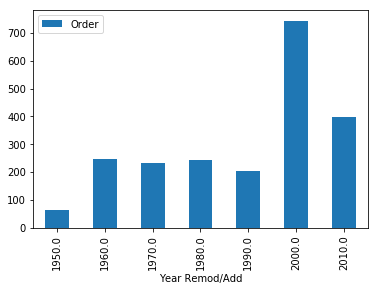

In [80]:
print('Count values on 1950:',data['Year Remod/Add'].apply(lambda x: np.where(x == 1950, np.nan,x)).isnull().sum())
# updating those values with Nan as data are probably incorrect
data['Year Remod/Add'] = data['Year Remod/Add'].apply(lambda x: np.where(x == 1950, np.nan,x))
# Also rounding results to 10
data['Year Remod/Add'] = round(data['Year Remod/Add'],-1)
data[['Year Remod/Add','Order']].groupby('Year Remod/Add').count().plot(kind='bar')
plt.show()

In [81]:
# handle test data
# updating those values with Nan as data are probably incorrect
data_test['Year Remod/Add'] = data_test['Year Remod/Add'].apply(lambda x: np.where(x == 1950, np.nan,x))
# Also rounding results to 10
data_test['Year Remod/Add'] = round(data_test['Year Remod/Add'],-1)

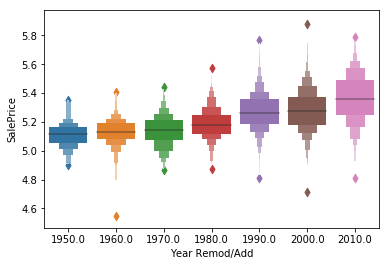

In [82]:
c = 'Year Remod/Add'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Roof Style & Roof Matl (Nominal) - clean

In [83]:
data['Roof Style'].unique()

array(['Gable', 'Hip', 'Flat', 'Gambrel', 'Mansard', 'Shed'], dtype=object)

In [84]:
data['Roof Matl'].unique()

array(['CompShg', 'Tar&Grv', 'WdShake', 'WdShngl', 'Metal', 'ClyTile',
       'Membran'], dtype=object)

In [85]:
# handle test data
data_test['Roof Style'].unique()

array(['Gable', 'Mansard', 'Hip', 'Gambrel', 'Flat'], dtype=object)

In [86]:
data['Roof Matl'].unique()

array(['CompShg', 'Tar&Grv', 'WdShake', 'WdShngl', 'Metal', 'ClyTile',
       'Membran'], dtype=object)

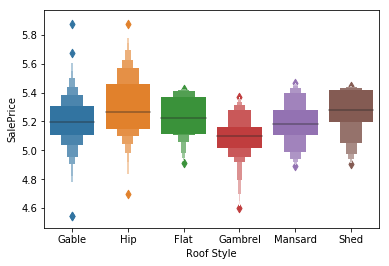

In [87]:
c = 'Roof Style'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

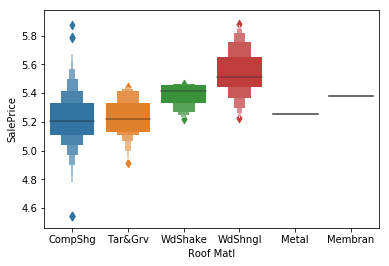

In [88]:
c = 'Roof Matl'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Exterior 1st & 2nd (Nominal) - clean

In [89]:
data['Exterior 1st'].unique()

array(['VinylSd', 'Wd Sdng', 'CemntBd', 'BrkFace', 'MetalSd', 'Plywood',
       'HdBoard', 'Stucco', 'Stone', 'CBlock', 'AsbShng', 'WdShing',
       'BrkComm', 'PreCast', 'AsphShn', 'ImStucc'], dtype=object)

In [90]:
data['Exterior 2nd'].unique()

array(['VinylSd', 'Wd Sdng', 'CmentBd', 'BrkFace', 'MetalSd', 'Plywood',
       'HdBoard', 'Stucco', 'Wd Shng', 'CBlock', 'Stone', 'ImStucc',
       'AsbShng', 'Brk Cmn', 'AsphShn', 'PreCast'], dtype=object)

In [91]:
# handle test data
data_test['Exterior 1st'].unique()

array(['MetalSd', 'VinylSd', 'Wd Sdng', 'AsbShng', 'Plywood', 'HdBoard',
       'CemntBd', 'WdShing', 'BrkFace', 'Stucco'], dtype=object)

In [92]:
data_test['Exterior 2nd'].unique()

array(['MetalSd', 'VinylSd', 'Wd Sdng', 'AsbShng', 'Plywood', 'CmentBd',
       'Wd Shng', 'HdBoard', 'Stucco', 'BrkFace', 'Brk Cmn', 'Stone',
       'ImStucc', 'Other', 'CBlock'], dtype=object)

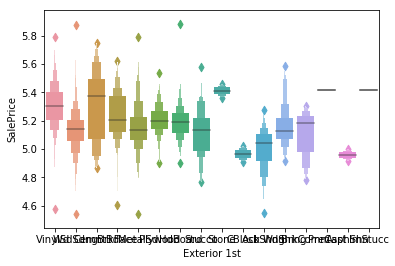

In [93]:
c = 'Exterior 1st'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

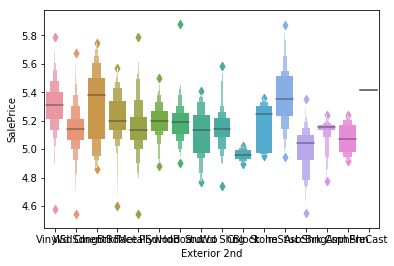

In [94]:
c = 'Exterior 2nd'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Mas Vnr Type (Nominal) - handle NAs

In [95]:
data['Mas Vnr Type'].unique()

array(['None', 'BrkFace', 'Stone', nan, 'BrkCmn', 'CBlock'], dtype=object)

In [96]:
data[['Mas Vnr Type','Order']].groupby('Mas Vnr Type').count()

,Order
Mas Vnr Type,
BrkCmn,21
BrkFace,736
CBlock,1
None,1442
Stone,210


In [97]:
# I decided to replace NAs with None as it is the higher number of value and assume best representation as well
print('Count NA:',data['Mas Vnr Type'].isnull().sum())
data['Mas Vnr Type'].fillna(value='None',inplace=True)

Count NA: 20


In [98]:
# handle test data
data_test['Mas Vnr Type'].fillna(value='None',inplace=True)

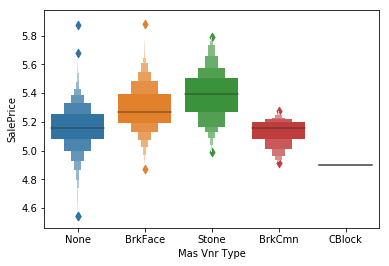

In [99]:
c = 'Mas Vnr Type'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Mas Vnr Area (Continous) - handle outlier (1x)

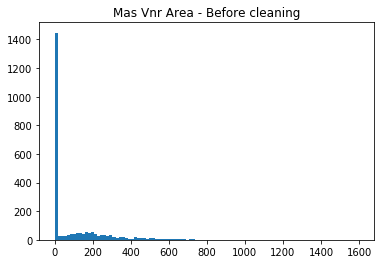

In [100]:
# This is a large number of properties with Mas Vnr Area = 0 but seems aligned with Mas Vnr Type = None numbers.
plt.hist(data['Mas Vnr Area'], bins=100)
plt.title('Mas Vnr Area - Before cleaning')
plt.show()

In [101]:
# This is a large number of properties with Mas Vnr Area = 0 but seems aligned with Mas Vnr Type = None numbers.
print('Count NA:',data['Mas Vnr Area'].isnull().sum())
data['Mas Vnr Area'].fillna(value=0,inplace=True)

Count NA: 20


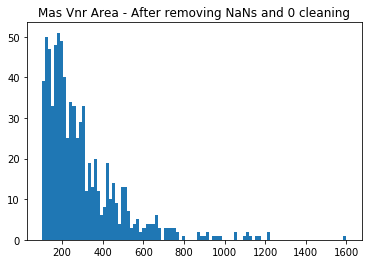

In [102]:
plt.hist(data[data['Mas Vnr Area'] > 100]['Mas Vnr Area'], bins=100)
plt.title('Mas Vnr Area - After removing NaNs and 0 cleaning')
plt.show()

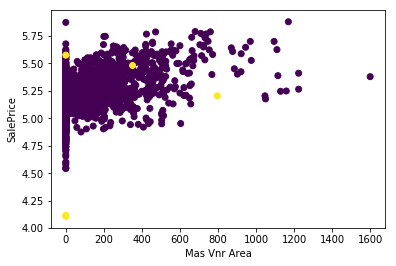

In [103]:
x = 'Mas Vnr Area'
y = 'SalePrice'
plt.scatter(data[x], np.log10(data[y]), c=outlier)
plt.xlabel(x)
plt.ylabel(y)
plt.show()

In [104]:
# Decided to tag as outlier the one value above 1500
print('Outliers pre:',outlier.sum())
outlier = (data['Mas Vnr Area']  > 1500) | outlier
print('Outliers post:',outlier.sum())

Outliers pre: 9
Outliers post: 10


In [105]:
# handle test data
data_test['Mas Vnr Area'].fillna(value=0,inplace=True)

### Exter Qual & Exter Cond (Ordinal) - convert to numerical scale

In [106]:
data['Exter Qual'].unique()

array(['Gd', 'TA', 'Fa', 'Ex'], dtype=object)

In [107]:
data['Exter Cond'].unique()

array(['TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [108]:
# Decide to convert to numerical based
# Update for both train and test set
data['Exter Qual'].replace({'Ex': 5,'Gd': 4,'TA': 3,'Fa':2,'Po':1},inplace=True)
data_test['Exter Qual'].replace({'Ex': 5,'Gd': 4,'TA': 3,'Fa':2,'Po':1},inplace=True)

In [109]:
# Decide to convert to numerical based
# Update for both train and test set
data['Exter Cond'].replace({'Ex': 5,'Gd': 4,'TA': 3,'Fa':2,'Po':1},inplace=True)
data_test['Exter Cond'].replace({'Ex': 5,'Gd': 4,'TA': 3,'Fa':2,'Po':1},inplace=True)

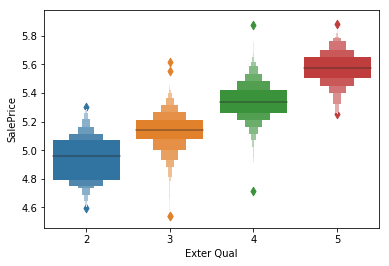

In [110]:
c = 'Exter Qual'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

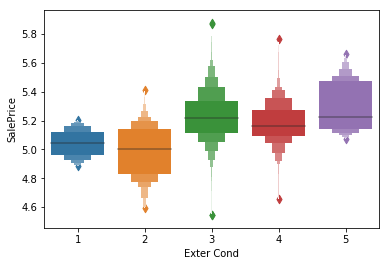

In [111]:
c = 'Exter Cond'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Foundation (Nominal) - clean

In [112]:
data['Foundation'].unique()

array(['PConc', 'CBlock', 'BrkTil', 'Slab', 'Stone', 'Wood'], dtype=object)

In [113]:
# handle test data
data_test['Foundation'].unique()

array(['CBlock', 'PConc', 'Stone', 'Slab', 'BrkTil'], dtype=object)

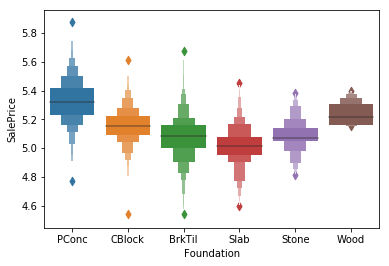

In [114]:
c = 'Foundation'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Bsmt Qual & Bsmt Cond & Bsmt Exposure (Ordinal) - convert to numerical scale

In [115]:
data['Bsmt Qual'].unique()

array(['Gd', 'TA', 'Ex', nan, 'Fa', 'Po'], dtype=object)

In [116]:
data['Bsmt Cond'].unique()

array(['TA', 'Gd', 'Fa', nan, 'Ex', 'Po'], dtype=object)

In [117]:
data['Bsmt Exposure'].unique()

array(['No', 'Av', 'Mn', 'Gd', nan], dtype=object)

In [118]:
data['Bsmt Qual'].replace({'Ex': 5,'Gd': 4,'TA': 3,'Fa':2,'Po':1},inplace=True)
data_test['Bsmt Qual'].replace({'Ex': 5,'Gd': 4,'TA': 3,'Fa':2,'Po':1},inplace=True)
data['Bsmt Qual'].fillna(value=0,inplace=True)
data_test['Bsmt Qual'].fillna(value=0,inplace=True)

In [119]:
data['Bsmt Cond'].replace({'Ex': 5,'Gd': 4,'TA': 3,'Fa':2,'Po':1},inplace=True)
data_test['Bsmt Cond'].replace({'Ex': 5,'Gd': 4,'TA': 3,'Fa':2,'Po':1},inplace=True)
data['Bsmt Cond'].fillna(value=0,inplace=True)
data_test['Bsmt Cond'].fillna(value=0,inplace=True)

In [120]:
data['Bsmt Exposure'].replace({'Gd': 4,'Av': 3,'Mn': 2,'No':1},inplace=True)
data_test['Bsmt Exposure'].replace({'Gd': 4,'Av': 3,'Mn': 2,'No':1},inplace=True)
data['Bsmt Exposure'].fillna(value=0,inplace=True)
data_test['Bsmt Exposure'].fillna(value=0,inplace=True)

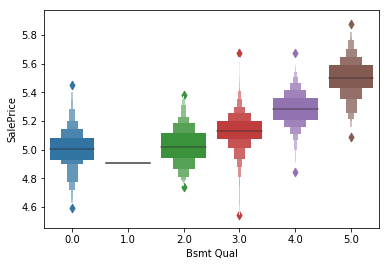

In [121]:
c = 'Bsmt Qual'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

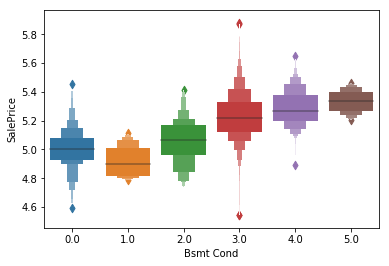

In [122]:
c = 'Bsmt Cond'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

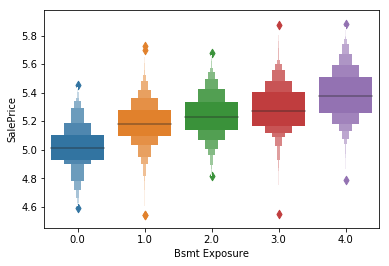

In [123]:
c = 'Bsmt Exposure'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### BsmtFin Type 1 & BsmtFin Type 2 (Ordinal) - convert to numerical scale

In [124]:
data['BsmtFin Type 1'].unique()

array(['GLQ', 'Unf', 'Rec', 'LwQ', 'BLQ', 'ALQ', nan], dtype=object)

In [125]:
data['BsmtFin Type 2'].unique()

array(['Unf', 'LwQ', 'BLQ', nan, 'Rec', 'ALQ', 'GLQ'], dtype=object)

In [126]:
data['BsmtFin Type 1'].replace({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1},inplace=True)
data_test['BsmtFin Type 1'].replace({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1},inplace=True)
data['BsmtFin Type 1'].fillna(value=0,inplace=True)
data_test['BsmtFin Type 1'].fillna(value=0,inplace=True)

In [127]:
data['BsmtFin Type 2'].replace({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1},inplace=True)
data_test['BsmtFin Type 2'].replace({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1},inplace=True)
data['BsmtFin Type 2'].fillna(value=0,inplace=True)
data_test['BsmtFin Type 2'].fillna(value=0,inplace=True)

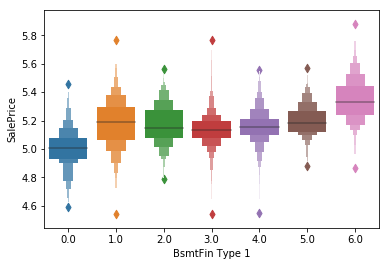

In [128]:
c = 'BsmtFin Type 1'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

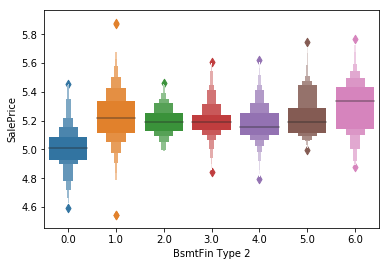

In [129]:
c = 'BsmtFin Type 2'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### BsmtFin SF 1 + 2 & Bsmt UNF SF & Total Bsmt SF (Continuous) - handle outliers

Count NaN SF 1: 1
Count >0 SF 1: 1656


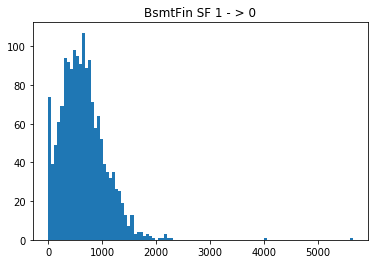

In [130]:
print('Count NaN SF 1:',data['BsmtFin SF 1'].isnull().sum())
print('Count >0 SF 1:',data[data['BsmtFin SF 1']>0]['BsmtFin SF 1'].count())
data['BsmtFin SF 1'].fillna(value=0,inplace=True)
data_test['BsmtFin SF 1'].fillna(value=0,inplace=True) # handle test data
plt.hist(data[data['BsmtFin SF 1'] > 0]['BsmtFin SF 1'], bins=100)
plt.title('BsmtFin SF 1 - > 0')
plt.show()

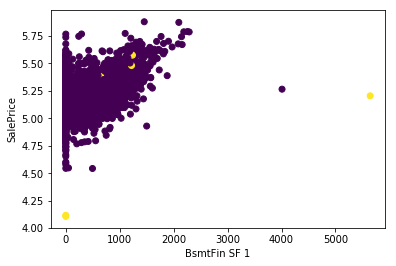

In [131]:
x = 'BsmtFin SF 1'
y = 'SalePrice'
plt.scatter(data[x], np.log10(data[y]), c=outlier)
plt.xlabel(x)
plt.ylabel(y)
plt.show()

In [132]:
# Decide to tag as outlier values above 3000
print('Outliers pre:',outlier.sum())
outlier = (data['BsmtFin SF 1']  > 3000) | outlier
print('Outliers post:',outlier.sum())

Outliers pre: 10
Outliers post: 11


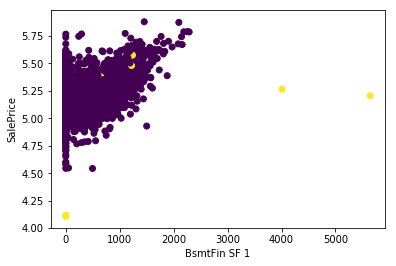

In [133]:
x = 'BsmtFin SF 1'
y = 'SalePrice'
plt.scatter(data[x], np.log10(data[y]), c=outlier)
plt.xlabel(x)
plt.ylabel(y)
plt.show()

Count NaN SF 2: 1
Count >0 SF 2: 294


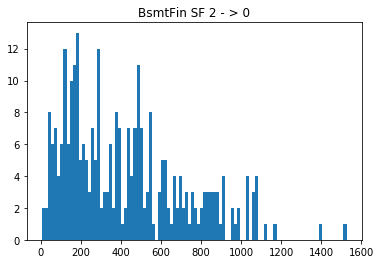

In [134]:
print('Count NaN SF 2:',data['BsmtFin SF 2'].isnull().sum())
print('Count >0 SF 2:',data[data['BsmtFin SF 2']>0]['BsmtFin SF 2'].count())
data['BsmtFin SF 2'].fillna(value=0,inplace=True)
data_test['BsmtFin SF 2'].fillna(value=0,inplace=True) # handle test data
plt.hist(data[data['BsmtFin SF 2'] > 0]['BsmtFin SF 2'], bins=100)
plt.title('BsmtFin SF 2 - > 0')
plt.show()
# Overall less than 300 values above 0. Decide not to remove any values as outliers here

Count NaN Unf: 1
Count >0 Unf: 2219


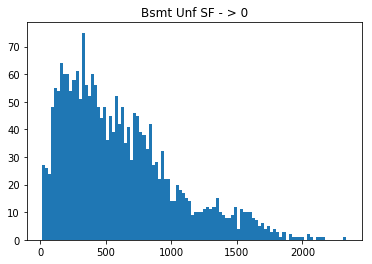

In [135]:
print('Count NaN Unf:',data['Bsmt Unf SF'].isnull().sum())
print('Count >0 Unf:',data[data['Bsmt Unf SF']>0]['Bsmt Unf SF'].count())
data['Bsmt Unf SF'].fillna(value=0,inplace=True)
data_test['Bsmt Unf SF'].fillna(value=0,inplace=True) # handle test data
plt.hist(data[data['Bsmt Unf SF'] > 0]['Bsmt Unf SF'], bins=100)
plt.title('Bsmt Unf SF - > 0')
plt.show()
# Decide to not consider as values as outliers

Count NaN Total Bsmt: 1
Count >0 Total Bsmt: 2359


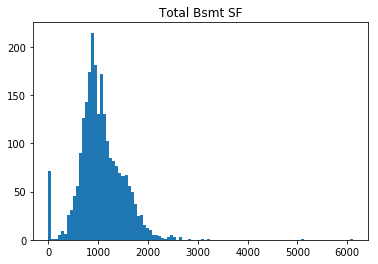

In [136]:
print('Count NaN Total Bsmt:',data['Total Bsmt SF'].isnull().sum())
print('Count >0 Total Bsmt:',data[data['Total Bsmt SF']>0]['Total Bsmt SF'].count())
data['Total Bsmt SF'].fillna(value=0,inplace=True)
data_test['Total Bsmt SF'].fillna(value=0,inplace=True) # handle test data
plt.hist(data[data['Total Bsmt SF'] > -1]['Total Bsmt SF'], bins=100)
plt.title('Total Bsmt SF')
plt.show()

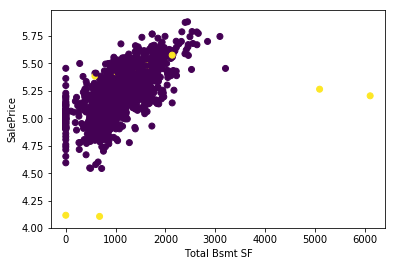

In [137]:
x = 'Total Bsmt SF'
y = 'SalePrice'
plt.scatter(data[x], np.log10(data[y]), c=outlier)
plt.xlabel(x)
plt.ylabel(y)
plt.show()

In [138]:
#(np.abs((data[data['Total Bsmt SF']>0]['Total Bsmt SF'] - data[data['Total Bsmt SF']>0]['Total Bsmt SF'].mean()) / data[data['Total Bsmt SF']>0]['Total Bsmt SF'].std()) > 3).sum()
# Considering only values above 0 to identify outliers
# 21 z-score values above abs(3) - choose 3 std as 2 seems too restrictive

data[data['Total Bsmt SF'] > 3000]['Total Bsmt SF']

71      5095.0
602     3206.0
1500    6110.0
2393    3094.0
Name: Total Bsmt SF, dtype: float64

In [139]:
print('Outliers pre:',outlier.sum())
outlier = (data['Total Bsmt SF'] > 3000) | outlier
print('Outiers post:',outlier.sum())

Outliers pre: 11
Outiers post: 13


### Heating (Nominal) - clean

In [140]:
data['Heating'].unique()

array(['GasA', 'GasW', 'Wall', 'Grav', 'OthW', 'Floor'], dtype=object)

In [141]:
# handle test data
data_test['Heating'].unique()

array(['GasA', 'GasW', 'Grav', 'Wall', 'OthW'], dtype=object)

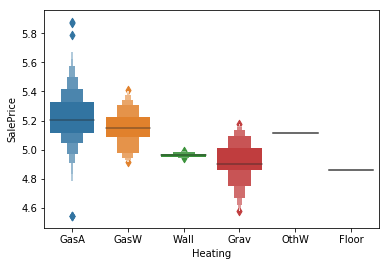

In [142]:
c = 'Heating'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### HeatingQC (Ordinal) - convert to numerical scale

In [143]:
# Decide to create scale starting at 1 as 0 would have means inexistant
data['Heating QC'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)
data_test['Heating QC'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)

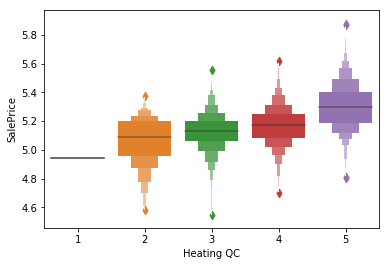

In [144]:
c = 'Heating QC'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Central Air (Nominal) - clean

In [145]:
data['Central Air'].unique()

array(['Y', 'N'], dtype=object)

In [146]:
# handle test data
data_test['Central Air'].unique()

array(['Y', 'N'], dtype=object)

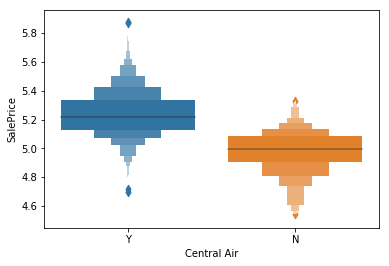

In [147]:
c = 'Central Air'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Electrical (Ordinal) - handle Nan

In [148]:
print('Count NaN:',data['Electrical'].isnull().sum())
data['Electrical'].unique()
# I don't know the scale of quality between each types and therefore deciding to keep as Nominal

Count NaN: 1


array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', nan, 'Mix'], dtype=object)

In [149]:
# check what is the most common type to assign the only Nan to this type
data[['Electrical','Order']].groupby('Electrical').count().sort_values(by='Order',ascending=False)

,Order
Electrical,
SBrkr,2223
FuseA,160
FuseF,38
FuseP,7
Mix,1


In [150]:
data['Electrical'].fillna(value='SBrkr',inplace=True)

In [151]:
# handle test data
data_test['Electrical'].fillna(value='SBrkr',inplace=True)

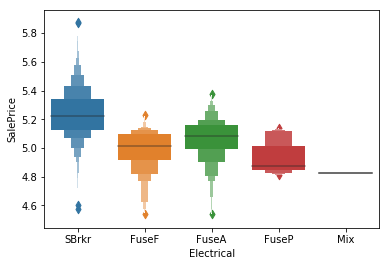

In [152]:
c = 'Electrical'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### 1st & 2nd Flr SF (Continuous) - handle outliers 1st Floor

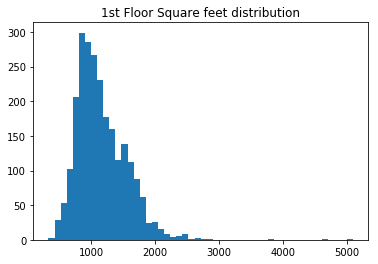

In [153]:
plt.hist(data['1st Flr SF'],bins=50)
plt.title('1st Floor Square feet distribution')
plt.show()

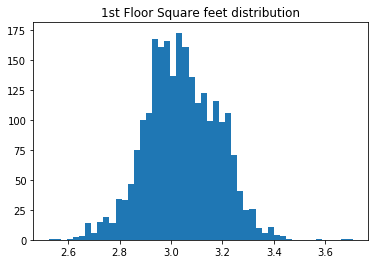

In [154]:
plt.hist(np.log10(data['1st Flr SF']),bins=50)
plt.title('1st Floor Square feet distribution')
plt.show()

In [155]:
# creating function for z-score as I realize I am re-writting this part of the code several times
def z_score(x):
    return np.abs((x - x.mean()) / x.std())

In [156]:
(z_score(np.log10(data['1st Flr SF'])) > 3).sum()
# considering 3 std for outliers we can identify 23 of them. Let's have a look at them

6

In [157]:
data[z_score(np.log10(data['1st Flr SF'])) > 3]['1st Flr SF']
# All of them are large surface

71      5095
234      334
463      407
494      372
1500    4692
2056    3820
Name: 1st Flr SF, dtype: int64

In [158]:
print('Outlier pre:',outlier.sum())
outlier = (z_score(np.log10(data['1st Flr SF'])) > 3) | outlier
print('Outlier post:',outlier.sum())

Outlier pre: 13
Outlier post: 17


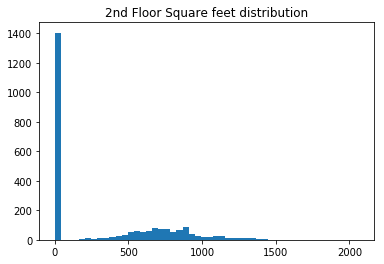

In [159]:
plt.hist(data['2nd Flr SF'],bins=50)
plt.title('2nd Floor Square feet distribution')
plt.show()

C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


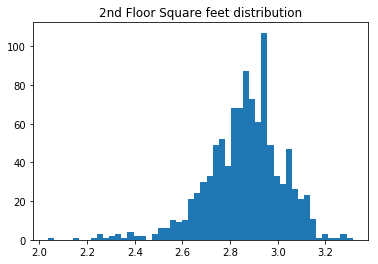

In [160]:
plt.hist(np.log10(data['2nd Flr SF'] - 1),bins=50)
plt.title('2nd Floor Square feet distribution')
plt.show()

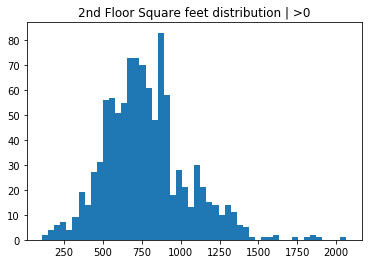

In [161]:
plt.hist(data[data['2nd Flr SF'] > 0]['2nd Flr SF'],bins=50)
plt.title('2nd Floor Square feet distribution | >0')
plt.show()
# Decided to not remove any outliers

### Low Qual Fin SF (Continous) - clean

Count Low Qual = 0: 2400


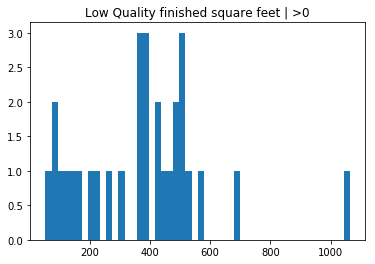

In [162]:
print('Count Low Qual = 0:',(data['Low Qual Fin SF'] == 0).sum())
plt.hist(data[data['Low Qual Fin SF'] != 0]['Low Qual Fin SF'], bins=50)
plt.title('Low Quality finished square feet | >0')
plt.show()

### Gr Liv Area (Continous)

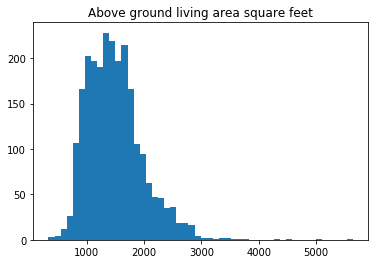

In [163]:
plt.hist(data['Gr Liv Area'], bins=50)
plt.title('Above ground living area square feet')
plt.show()

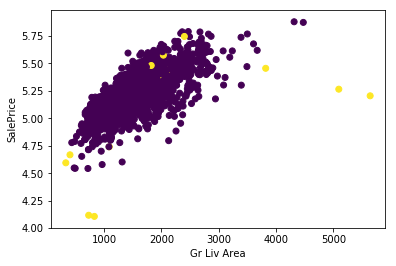

In [164]:
x = 'Gr Liv Area'
y = 'SalePrice'
plt.scatter(data[x], np.log10(data[y]), c=outlier)
plt.xlabel(x)
plt.ylabel(y)
plt.show()

In [165]:
print('Count data points above 3 std:',(z_score(data['Gr Liv Area']) > 3).sum())
data[(z_score(data['Gr Liv Area']) > 3)]['Gr Liv Area']
# below list of entries to be tagged as outliers

Count data points above 3 std: 16


71      5095
102     4476
237     4316
306     3672
635     3086
647     3608
838     3500
895     3078
1072    3395
1152    3238
1500    5642
1582    3112
1724    3390
1927    3194
2056    3820
2092    3493
Name: Gr Liv Area, dtype: int64

In [166]:
print('Outlier pre:',outlier.sum())
outlier = (z_score(data['Gr Liv Area']) > 3) | outlier
print('Outlier post:',outlier.sum())

Outlier pre: 17
Outlier post: 30


### Bsmt Full Bath & Bsmt Half Bath & Full Bath & Half Bath (Discrete) - handle NaNs

In [167]:
print('Count NaNs:',data['Bsmt Full Bath'].isnull().sum())
data['Bsmt Full Bath'].unique()

Count NaNs: 2


array([ 0.,  1., nan,  3.,  2.])

In [168]:
# fill NaNs with 0 as no data probably means 0
data['Bsmt Full Bath'].fillna(value=0, inplace=True)
data_test['Bsmt Full Bath'].fillna(value=0, inplace=True) # handle test data

In [169]:
print('Count NaNs:',data['Bsmt Half Bath'].isnull().sum())
data['Bsmt Half Bath'].unique()

Count NaNs: 2


array([ 0.,  1., nan,  2.])

In [170]:
# fill NaNs with 0 as no data probably means 0
data['Bsmt Half Bath'].fillna(value=0, inplace=True)
data_test['Bsmt Half Bath'].fillna(value=0, inplace=True) # handle test data

In [171]:
print('Count NaNs:',data['Full Bath'].isnull().sum())
data['Full Bath'].unique()

Count NaNs: 0


array([2, 1, 3, 0, 4], dtype=int64)

In [172]:
print('Count NaNs:',data['Full Bath'].isnull().sum())
data['Half Bath'].unique()

Count NaNs: 0


array([1, 0, 2], dtype=int64)

In [173]:
# handle test data
data_test['Full Bath'].unique()

array([1, 2, 0, 3, 4], dtype=int64)

In [174]:
data_test['Half Bath'].unique()

array([1, 0, 2], dtype=int64)

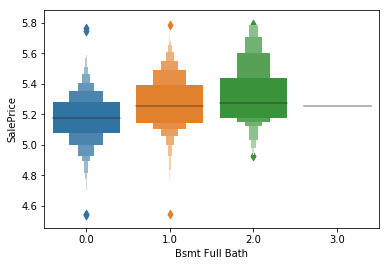

In [175]:
c = 'Bsmt Full Bath'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

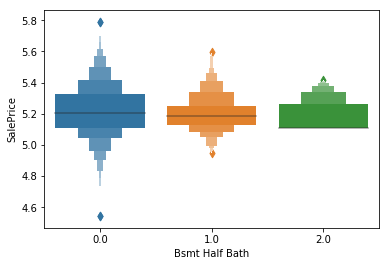

In [176]:
c = 'Bsmt Half Bath'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

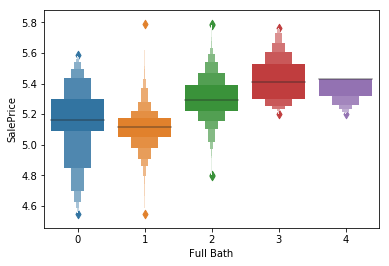

In [177]:
c = 'Full Bath'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

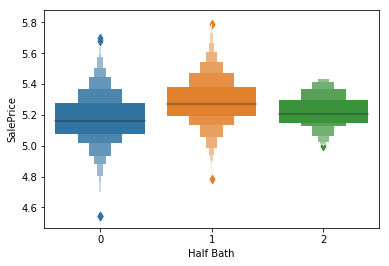

In [178]:
c = 'Half Bath'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Bedroom & Kitchen (Discrete) - clean but watch column name

In [179]:
print('Count NaNs:',data['Bedroom AbvGr'].isnull().sum())
data['Bedroom AbvGr'].unique()

Count NaNs: 0


array([4, 2, 3, 1, 5, 0, 6, 8], dtype=int64)

In [180]:
print('Count NaNs:',data['Kitchen AbvGr'].isnull().sum())
data['Kitchen AbvGr'].unique()

Count NaNs: 0


array([1, 2, 3, 0], dtype=int64)

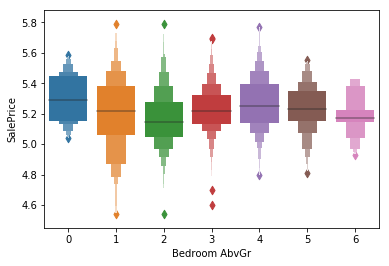

In [181]:
c = 'Bedroom AbvGr'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

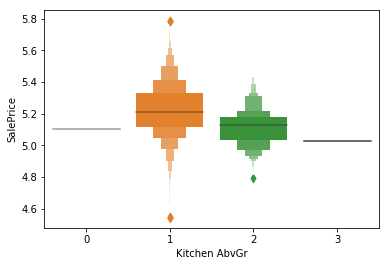

In [182]:
c = 'Kitchen AbvGr'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Kitchen Qual (Ordinal) - convert to numerical scale

In [183]:
print('Count NaNs:',data['Kitchen Qual'].isnull().sum())
data['Kitchen Qual'].unique()

Count NaNs: 0


array(['Gd', 'TA', 'Ex', 'Fa', 'Po'], dtype=object)

In [184]:
data['Kitchen Qual'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)
data_test['Kitchen Qual'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)

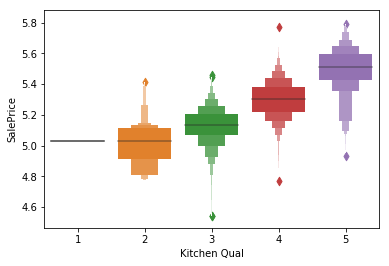

In [185]:
c = 'Kitchen Qual'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### TotRmsAbvGrd (Discrete) - clean

In [186]:
print('Count NaNs:',data['TotRms AbvGrd'].isnull().sum())
data['TotRms AbvGrd'].unique()

Count NaNs: 0


array([ 8,  5,  6,  9,  7,  4, 10, 12, 11, 15,  3,  2, 14, 13],
      dtype=int64)

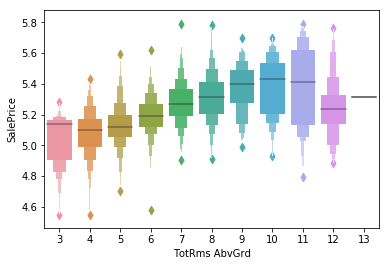

In [187]:
c = 'TotRms AbvGrd'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Functional (Ordinal) - convert to numerical scale

In [188]:
print('Count NaNs:',data['Functional'].isnull().sum())
data['Functional'].unique()

Count NaNs: 0


array(['Typ', 'Mod', 'Maj1', 'Min2', 'Min1', 'Maj2', 'Sal', 'Sev'],
      dtype=object)

In [189]:
data['Functional'].replace({'Typ':8,'Min1':7,'Min2':6,'Mod':5,'Maj1':4,'Maj2':3,'Sev':2,'Sal':1},inplace=True)
data_test['Functional'].replace({'Typ':8,'Min1':7,'Min2':6,'Mod':5,'Maj1':4,'Maj2':3,'Sev':2,'Sal':1},inplace=True)

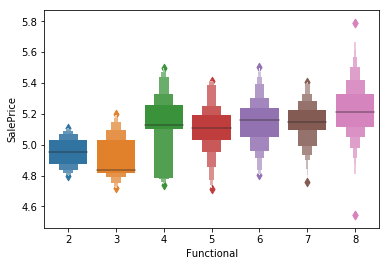

In [190]:
c = 'Functional'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Fireplaces (Discrete) - clean

In [191]:
print('Count NaNs:',data['Fireplaces'].isnull().sum())
data['Fireplaces'].unique()

Count NaNs: 0


array([1, 0, 2, 3, 4], dtype=int64)

In [192]:
# handle test data
data_test['Fireplaces'].unique()

array([1, 0, 2, 3], dtype=int64)

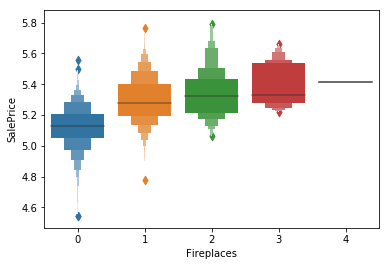

In [193]:
c = 'Fireplaces'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### FireplacesQu (Ordinal) - convert to numerical scale

In [194]:
print('Count NaNs:',data['Fireplace Qu'].isnull().sum())
data['Fireplace Qu'].unique()

Count NaNs: 1186


array(['TA', 'Gd', nan, 'Fa', 'Po', 'Ex'], dtype=object)

In [195]:
data['Fireplace Qu'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)
data['Fireplace Qu'].fillna(value=0,inplace=True)
data_test['Fireplace Qu'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)
data_test['Fireplace Qu'].fillna(value=0,inplace=True)

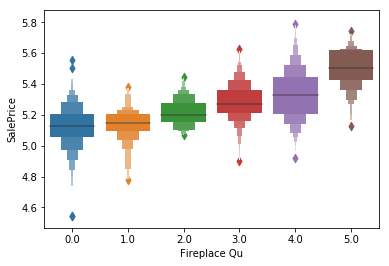

In [196]:
c = 'Fireplace Qu'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Garage Type (Nominal) - handle NaNs

In [197]:
print('Count NaNs:',data['Garage Type'].isnull().sum())
data['Garage Type'].unique()

Count NaNs: 136


array(['BuiltIn', 'Attchd', 'Detchd', nan, '2Types', 'Basment', 'CarPort'],
      dtype=object)

In [198]:
# NaN mean 'No Garage'
data['Garage Type'].fillna(value='No Garage',inplace=True)
data_test['Garage Type'].fillna(value='No Garage',inplace=True) # handle test data

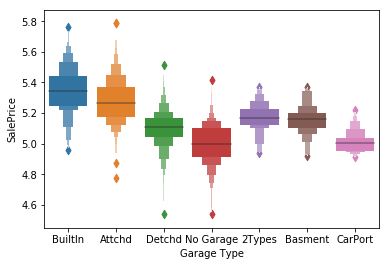

In [199]:
c = 'Garage Type'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Garage Yr Blt (Discrete) - handle NaNs

Count NaNs: 138


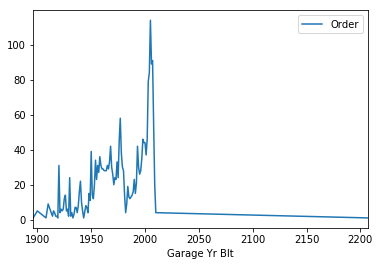

In [200]:
print('Count NaNs:',data['Garage Yr Blt'].isnull().sum())
data[['Garage Yr Blt','Order']].groupby('Garage Yr Blt').count().plot()
plt.show()

In [201]:
x = data[data['Garage Yr Blt'] > 2010]['Garage Yr Blt']
data['Garage Yr Blt'].replace(x,np.nan,inplace=True)
data['Garage Yr Blt'] = round(data['Garage Yr Blt'],-1)

# handle test data
y = data_test[data_test['Garage Yr Blt'] > 2010]['Garage Yr Blt']
data_test['Garage Yr Blt'].replace(x,np.nan,inplace=True)
data_test['Garage Yr Blt'] = round(data_test['Garage Yr Blt'],-1)

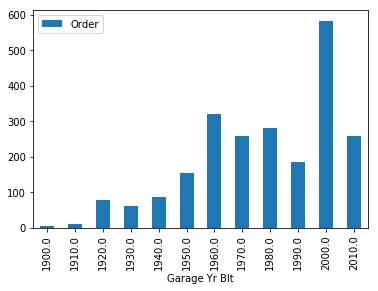

In [202]:
data[['Garage Yr Blt','Order']].groupby('Garage Yr Blt').count().plot(kind='bar')
plt.show()

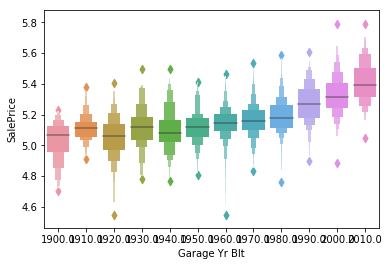

In [203]:
c = 'Garage Yr Blt'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

In [204]:
# how to handle Nans? Use year build of house? or is there no garage? 
# Based on previous variable it could be related to having no Garage. Suggest to keep NaNs?
# data['Garage Yr Blt'].fillna(value=data['Year Built'],inplace=True)

### Garage Finish (Ordinal) - convert to numerical scale

In [205]:
print('Count NaNs:',data['Garage Finish'].isnull().sum())
data['Garage Finish'].unique()
# keep NaNs as is as per previous variable discussion

Count NaNs: 138


array(['Fin', 'Unf', 'RFn', nan], dtype=object)

In [206]:
data['Garage Finish'].replace({'Fin':3,'RFn':2,'Unf':1},inplace=True)
data_test['Garage Finish'].replace({'Fin':3,'RFn':2,'Unf':1},inplace=True)

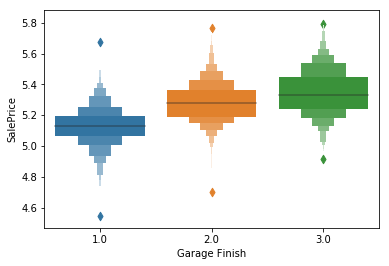

In [207]:
c = 'Garage Finish'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Garage Cars (Discrete) - clean

In [208]:
print('Count NaNs:',data['Garage Cars'].isnull().sum())
data['Garage Cars'].unique()
# keep NaNs as is as per previous variable discussion

Count NaNs: 1


array([ 2.,  1.,  3.,  0.,  4., nan])

In [209]:
data['Garage Cars'].fillna(value=0,inplace=True)
data_test['Garage Cars'].fillna(value=0,inplace=True) # handle test data

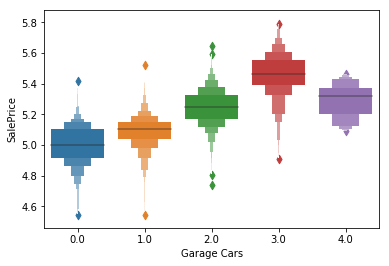

In [210]:
c = 'Garage Cars'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Garage Area (Continuous)

In [211]:
print('Count NaNs:',data['Garage Area'].isnull().sum())
data['Garage Area'].fillna(value=0,inplace=True)
data_test['Garage Area'].fillna(value=0,inplace=True) # handle test data

Count NaNs: 1


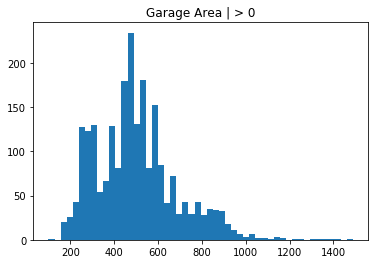

In [212]:
plt.hist(data[data['Garage Area'] > 0]['Garage Area'], bins=50)
plt.title('Garage Area | > 0')
plt.show()

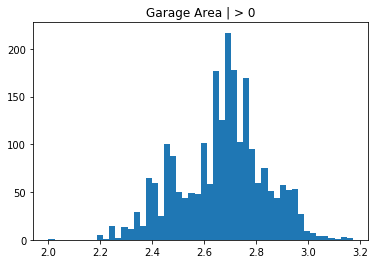

In [213]:
plt.hist(np.log10(data[data['Garage Area'] > 0]['Garage Area']), bins=50)
plt.title('Garage Area | > 0')
plt.show()

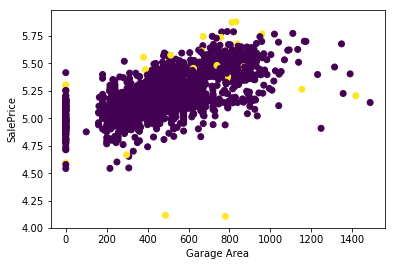

In [214]:
x = 'Garage Area'
y = 'SalePrice'
plt.scatter(data[x], np.log10(data[y]), c=outlier)
plt.xlabel(x)
plt.ylabel(y)
plt.show()

In [215]:
mean_garage = data[data['Garage Area']>0]['Garage Area'].mean()
std_garage = data[data['Garage Area']>0]['Garage Area'].std()
data[((data['Garage Area'] != 0) & ((np.abs(data['Garage Area']-mean_garage) / std_garage) > 3))]['Garage Area']

71      1154.0
339     1134.0
473     1314.0
580     1166.0
600     1092.0
690     1138.0
1176    1488.0
1212    1231.0
1464    1110.0
1479    1390.0
1500    1418.0
1631    1248.0
1950    1069.0
1956    1348.0
2075    1085.0
2228    1356.0
2411    1174.0
Name: Garage Area, dtype: float64

In [216]:
print('Outliers pre:',outlier.sum())
outlier = (data['Garage Area'] > 1200) | outlier
print('Outliers post:',outlier.sum())

Outliers pre: 30
Outliers post: 37


### Garage Qual & Garage Cond (Ordinal) - convert to numerical scale

In [217]:
print('Count NaNs:',data['Garage Qual'].isnull().sum())
data['Garage Qual'].unique()
# keep NaNs as is as per previous variables discussion

Count NaNs: 138


array(['TA', 'Fa', nan, 'Gd', 'Ex', 'Po'], dtype=object)

In [218]:
data['Garage Qual'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)
#data['Garage Qual'].fillna(value=0,inplace=True)
data_test['Garage Qual'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)
#data_test['Garage Qual'].fillna(value=0,inplace=True)

In [219]:
print('Count NaNs:',data['Garage Cond'].isnull().sum())
data['Garage Cond'].unique()
# keep NaNs as is as per previous variables discussion

Count NaNs: 138


array(['TA', nan, 'Fa', 'Gd', 'Ex', 'Po'], dtype=object)

In [220]:
data['Garage Cond'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)
#data['Garage Qual'].fillna(value=0,inplace=True)
data_test['Garage Cond'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)
#data_test['Garage Qual'].fillna(value=0,inplace=True)

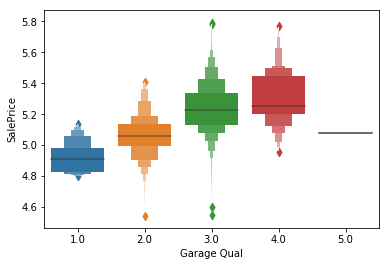

In [221]:
c = 'Garage Qual'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

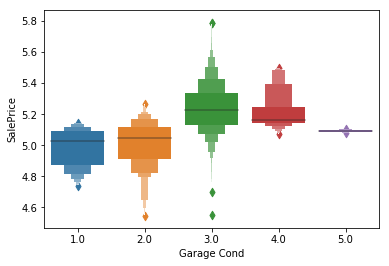

In [222]:
c = 'Garage Cond'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Paved Drive (Ordinal) - clean

In [223]:
print('Count NaNs:',data['Garage Cond'].isnull().sum())
data['Garage Cond'].unique()
# keep NaNs as is as per previous variables discussion
# keep as nominal instead of converting as different people may have different preferences on this. I don't see it as been ordinal

Count NaNs: 138


array([ 3., nan,  2.,  4.,  5.,  1.])

In [224]:
# handle test data
data_test['Garage Cond'].unique()

array([2, 3, nan, 4, 5], dtype=object)

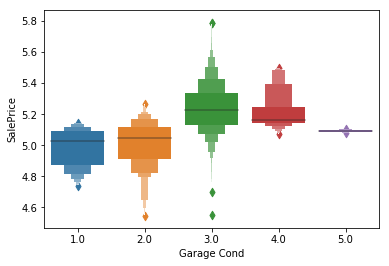

In [225]:
c = 'Garage Cond'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Wood Deck SF (Continous) - handle outliers

Count NaNs: 0


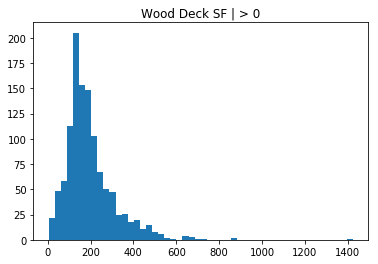

In [226]:
print('Count NaNs:',data['Wood Deck SF'].isnull().sum())
plt.hist(data[data['Wood Deck SF'] > 0]['Wood Deck SF'], bins=50)
plt.title('Wood Deck SF | > 0')
plt.show()

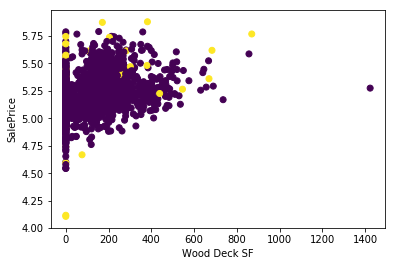

In [227]:
x = 'Wood Deck SF'
y = 'SalePrice'
plt.scatter(data[x], np.log10(data[y]), c=outlier)
plt.xlabel(x)
plt.ylabel(y)
plt.show()

In [228]:
# Decided to consider values above 800 as outliers
print('Outliers pre:',outlier.sum())
outlier = (data['Wood Deck SF'] > 800) | outlier
print('Outliers post:',outlier.sum())

Outliers pre: 37
Outliers post: 39


### Open Porch SF & Enclosed Porch & 3-Ssn & Screen Porch (Continuous) - handle outliers

Count NaNs: 0


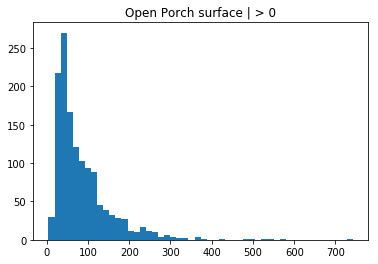

In [229]:
print('Count NaNs:',data['Open Porch SF'].isnull().sum())
plt.hist(data[data['Open Porch SF'] > 0]['Open Porch SF'], bins=50)
plt.title('Open Porch surface | > 0')
plt.show()

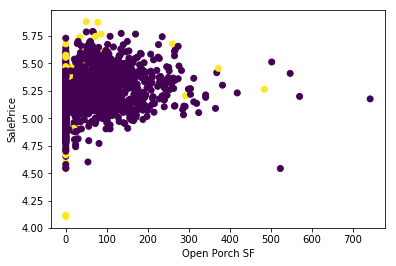

In [230]:
x = 'Open Porch SF'
y = 'SalePrice'
plt.scatter(data[x], np.log10(data[y]), c=outlier)
plt.xlabel(x)
plt.ylabel(y)
plt.show()

In [231]:
print('Outliers pre:',outlier.sum())
outlier = (data['Open Porch SF'] > 500) | outlier
print('Outliers post:',outlier.sum())

Outliers pre: 39
Outliers post: 44


Count NaNs: 0


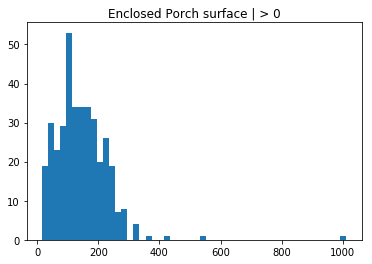

In [232]:
print('Count NaNs:',data['Enclosed Porch'].isnull().sum())
plt.hist(data[data['Enclosed Porch'] > 0]['Enclosed Porch'], bins=50)
plt.title('Enclosed Porch surface | > 0')
plt.show()

In [233]:
print('Outliers pre:',outlier.sum())
outlier = (data['Enclosed Porch'] > 400) | outlier
print('Outliers post:',outlier.sum())

Outliers pre: 44
Outliers post: 46


Count NaNs: 0


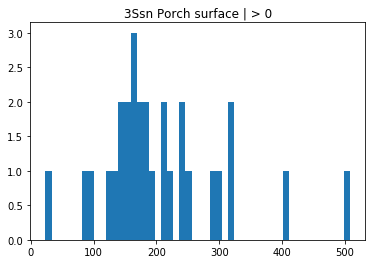

In [234]:
print('Count NaNs:',data['3Ssn Porch'].isnull().sum())
plt.hist(data[data['3Ssn Porch'] > 0]['3Ssn Porch'], bins=50)
plt.title('3Ssn Porch surface | > 0')
plt.show()
# Not considerung any outliers given the low number of data

Count NaNs: 0


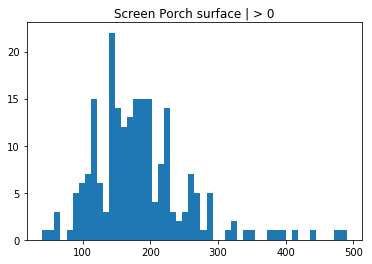

In [235]:
print('Count NaNs:',data['Screen Porch'].isnull().sum())
plt.hist(data[data['Screen Porch'] > 0]['Screen Porch'], bins=50)
plt.title('Screen Porch surface | > 0')
plt.show()
# Not considerung any outliers given the low number of data

### Pool Area (Continous) - clean

Count NaNs: 0


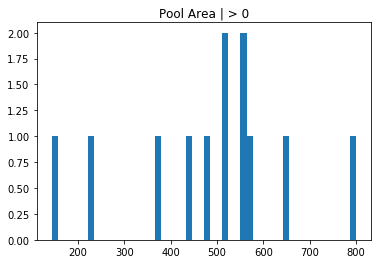

In [236]:
print('Count NaNs:',data['Pool Area'].isnull().sum())
plt.hist(data[data['Pool Area'] > 0]['Pool Area'], bins=50)
plt.title('Pool Area | > 0')
plt.show()
# Not considerung any outliers given the low number of data

### Pool QC (Ordinal) - convert to numerical scale

In [237]:
print('Count NaNs:',data['Pool QC'].isnull().sum())
data['Pool QC'].unique()

Count NaNs: 2418


array([nan, 'Fa', 'Ex', 'TA', 'Gd'], dtype=object)

In [238]:
data['Pool QC'].replace({'Ex':4,'Gd':3,'TA':2,'Fa':1},inplace=True)
data['Pool QC'].fillna(value=0,inplace=True)
data_test['Pool QC'].replace({'Ex':4,'Gd':3,'TA':2,'Fa':1},inplace=True)
data_test['Pool QC'].fillna(value=0,inplace=True)

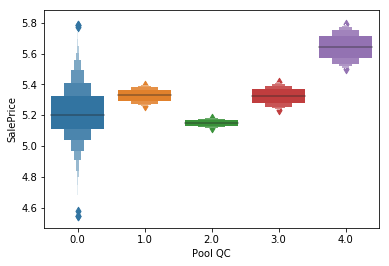

In [239]:
c = 'Pool QC'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Fence (Ordinal) - convert to numerical scale

In [240]:
print('Count NaNs:',data['Fence'].isnull().sum())
data['Fence'].unique()

Count NaNs: 1941


array([nan, 'MnPrv', 'MnWw', 'GdPrv', 'GdWo'], dtype=object)

In [241]:
data['Fence'].replace({'GdPrv':4,'MnPrv':3,'GdWo':2,'MnWw':1},inplace=True)
data['Fence'].fillna(value=0,inplace=True)
data_test['Fence'].replace({'GdPrv':4,'MnPrv':3,'GdWo':2,'MnWw':1},inplace=True)
data_test['Fence'].fillna(value=0,inplace=True)

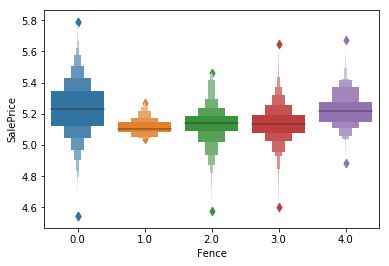

In [242]:
c = 'Fence'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Misc Feature (Nominal) - handle NaNs

In [243]:
print('Count NaNs:',data['Misc Feature'].isnull().sum())
data['Misc Feature'].unique()

Count NaNs: 2340


array([nan, 'Shed', 'Othr', 'Elev', 'Gar2', 'TenC'], dtype=object)

In [244]:
data['Misc Feature'].fillna(value='None',inplace=True)
data_test['Misc Feature'].fillna(value='None',inplace=True) # handle test data

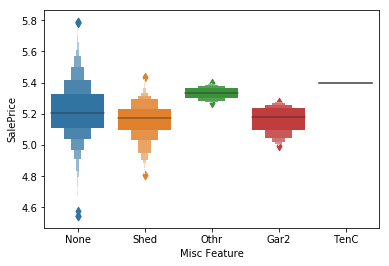

In [245]:
c = 'Misc Feature'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### Misc Val (Continuous) - clean

Count NaNs: 0


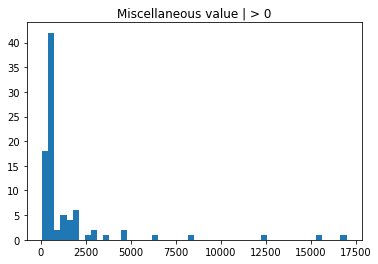

In [246]:
print('Count NaNs:',data['Misc Val'].isnull().sum())
plt.hist(data[data['Misc Val'] > 0]['Misc Val'], bins=50)
plt.title('Miscellaneous value | > 0')
plt.show()
# Not considerung any outliers given the low number of data

### Mo Sold & Yr Sold (Discrete) - clean

In [247]:
print('Count NaNs:',data['Mo Sold'].isnull().sum())
data['Mo Sold'].unique()

Count NaNs: 0


array([ 4,  6,  1,  5,  9,  3, 11,  2, 12,  7,  8, 10], dtype=int64)

In [248]:
data[['Mo Sold','Order']].groupby('Mo Sold').count()
# checking if distribution seems unbiased - seems ok

,Order
Mo Sold,
1,108
2,109
3,187
4,227
5,335
6,422
7,374
8,186
9,135


In [249]:
print('Count NaNs:',data['Yr Sold'].isnull().sum())
data['Yr Sold'].unique()

Count NaNs: 0


array([2009, 2006, 2007, 2010, 2008], dtype=int64)

In [250]:
data[['Yr Sold','Order']].groupby('Yr Sold').count()
# checking if distribution seems unbiased - seems ok

,Order
Yr Sold,
2006,514
2007,584
2008,530
2009,518
2010,284


### Sale Type & Sale Condition (Nominal) - clean

In [251]:
print('Count NaNs:',data['Sale Type'].isnull().sum())
data['Sale Type'].unique()

Count NaNs: 0


array(['WD ', 'New', 'ConLD', 'ConLI', 'CWD', 'COD', 'Oth', 'Con',
       'ConLw', 'VWD'], dtype=object)

In [252]:
print('Count NaNs:',data['Sale Condition'].isnull().sum())
data['Sale Condition'].unique()

Count NaNs: 0


array(['Normal', 'Family', 'Partial', 'Abnorml', 'Alloca', 'AdjLand'],
      dtype=object)

In [253]:
# handle test data
data_test['Sale Type'].unique()

array(['WD ', 'New', 'COD', 'ConLD', 'ConLw', 'CWD', 'ConLI', 'Oth'],
      dtype=object)

In [254]:
data_test['Sale Condition'].unique()

array(['Normal', 'Partial', 'Family', 'Abnorml', 'Alloca', 'AdjLand'],
      dtype=object)

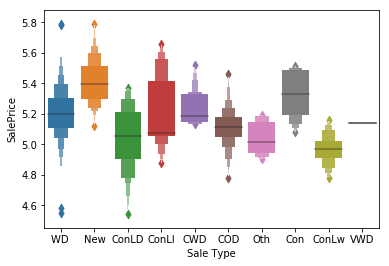

In [255]:
c = 'Sale Type'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

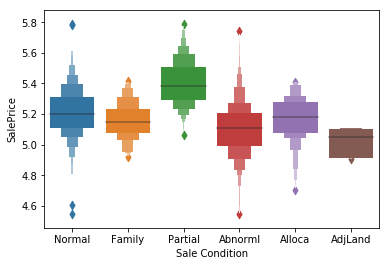

In [256]:
c = 'Sale Condition'
sns.boxenplot(data[~outlier][c],np.log10(data[~outlier]['SalePrice']));

### SalePrice (Continuous) - Output/target

Count NaNs: 0


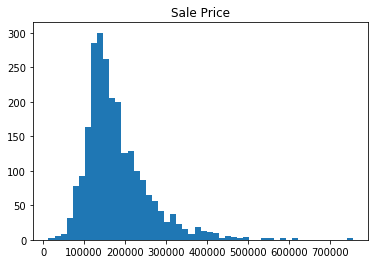

In [257]:
print('Count NaNs:',data['SalePrice'].isnull().sum())
plt.hist(data[data['SalePrice'] > 0]['SalePrice'], bins=50)
plt.title('Sale Price')
plt.show()

Count NaNs: 0


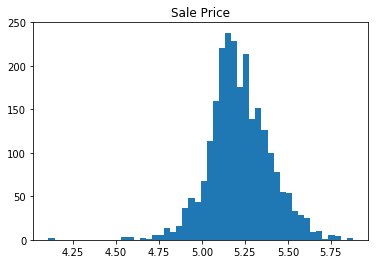

In [258]:
print('Count NaNs:',data['SalePrice'].isnull().sum())
plt.hist(np.log10(data[data['SalePrice'] > 0]['SalePrice']), bins=50)
plt.title('Sale Price')
plt.show()

In [259]:
print('Sale Price > 3 std:',(z_score(np.log10(data['SalePrice'])) > 3).sum())

Sale Price > 3 std: 18


In [260]:
data[z_score(np.log10(data['SalePrice'])) > 3]['SalePrice']
# all outliers are high prices

42       40000
102     745000
234      39300
237     755000
321     615000
363      45000
463      46500
491      13100
838     584500
977      34900
1213    610000
1464    591587
1519    611657
1654     35000
1757     12789
1857     37900
2142    582933
2379     35311
Name: SalePrice, dtype: int64

In [261]:
print('Outliers pre:',outlier.sum())
#outlier = (z_score(data['SalePrice']) > 3) | outlier
outlier = (z_score(np.log10(data['SalePrice'])) > 3) | outlier
print('Outliers post:',outlier.sum())

Outliers pre: 46
Outliers post: 56


### Identifying data removed as considered as outlier

As we some while working on each variable we tend to consider as outliers high values as usually lower limit is 0. Is this a correct way of doing it? Looking at the scatter plot it seems we would be able to predict correctly with the data points available.

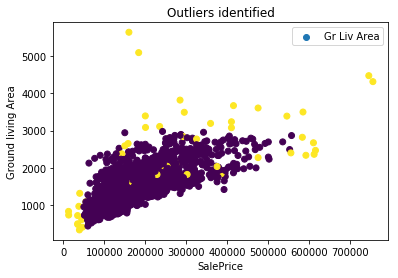

In [262]:
plt.scatter('SalePrice','Gr Liv Area',data=data,c=outlier)
plt.xlabel('SalePrice')
plt.ylabel('Ground living Area')
plt.title('Outliers identified')
plt.legend()
plt.show()

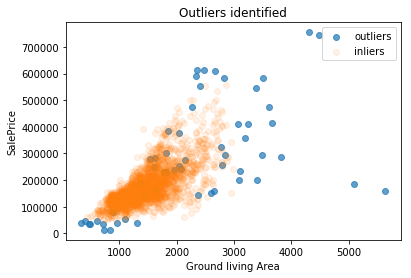

In [263]:
# beter option to call-out outliers in legend as well
plt.scatter(data.loc[outlier,'Gr Liv Area'],data.loc[outlier,'SalePrice'],alpha=0.7, label='outliers')
plt.scatter(data.loc[~outlier,'Gr Liv Area'],data.loc[~outlier,'SalePrice'],alpha=0.1,label='inliers')

plt.ylabel('SalePrice')
plt.xlabel('Ground living Area')
plt.title('Outliers identified')
plt.legend()
plt.show()

## (C) Feature engineering

*Feature engineering technics*
* Applying transformations - log,sqrt, poly
* Create indicator variables
* Combine numerical variable
* Combine binary variable
* other functions

### (i) Applying transformations (log)

In [264]:
import seaborn as sns
from scipy.stats import norm

In [265]:
# Copy data set to create data engineered
data_eng = data.copy()

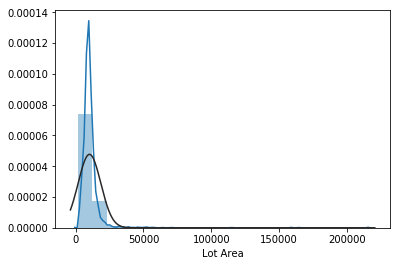

In [266]:
sns.distplot(data['Lot Area'], bins=20, fit=norm)
plt.show()

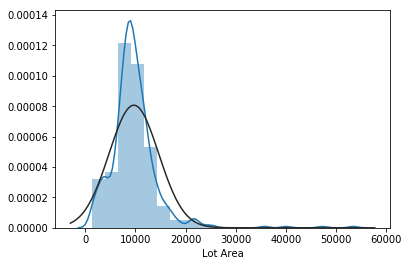

In [267]:
sns.distplot(data_test['Lot Area'], bins=20, fit=norm)
plt.show()

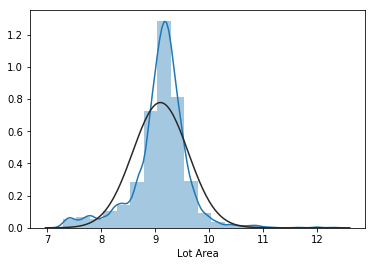

In [268]:
sns.distplot(np.log(data['Lot Area']), bins=20, fit=norm)
plt.show()

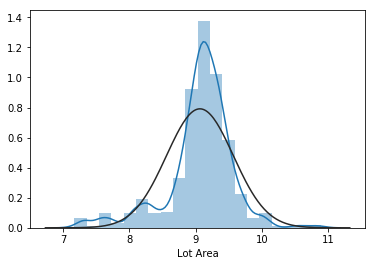

In [269]:
sns.distplot(np.log(data_test['Lot Area']), bins=20, fit=norm)
plt.show()

In [270]:
# Apply logarithmic transformation to Lot Area to remove skewed distribution
data_eng['Lot Area'] = np.log(data_eng['Lot Area'])
data_test['Lot Area'] = np.log(data_test['Lot Area']) # handle test data

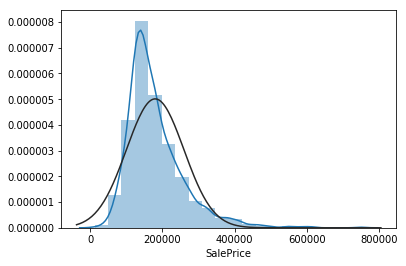

In [271]:
sns.distplot(data['SalePrice'], bins=20, fit=norm)
plt.show()

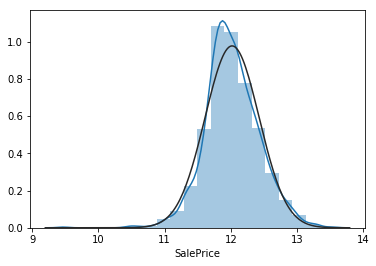

In [272]:
sns.distplot(np.log(data['SalePrice']), bins=20, fit=norm)
plt.show()

In [273]:
# Decided not to apply log transformation at this stage to SalePrice as when removing outliers had already a positive effect on distribution. Log applied later.

### (ii) Create indicator variable

In [274]:
# Create indicator to define if house was built or remod in last 10 years => NEW
data_eng['New or remod'] = ((data_eng['Year Built'] >= 2010) | (data_eng['Year Remod/Add'] >= 2010))*1
data_eng['New or remod'] = data_eng['New or remod'].map({0:'old',1:'new'})
# handle test data
data_test['New or remod'] = ((data_test['Year Built'] >= 2010) | (data_test['Year Remod/Add'] >= 2010))*1
data_test['New or remod'] = data_test['New or remod'].map({0:'old',1:'new'})

In [275]:
# Create indicator to count number of "positive conditions" - (between 0 and 2)
data_eng['Condition Count'] = np.max(data_eng['Condition 1'] != 'Norm')*1 + (data_eng['Condition 2'] != 'Norm')*1
# handle test data
data_test['Condition Count'] = np.max(data_test['Condition 1'] != 'Norm')*1 + (data_test['Condition 2'] != 'Norm')*1

### (iii) Combine numerical variable

In [276]:
# Sum number of baths and remove both current fields as believe it does't make major difference if Bath in Basement or not
data_eng['Bath'] = data_eng['Bsmt Full Bath'] + data_eng['Full Bath'] + data_eng['Bsmt Half Bath']/2 + data_eng['Half Bath']/2
data_eng.drop(columns=['Bsmt Full Bath','Full Bath','Bsmt Half Bath','Half Bath'],inplace=True)

# handle test data
data_test['Bath'] = data_test['Bsmt Full Bath'] + data_test['Full Bath'] + data_test['Bsmt Half Bath']/2 + data_test['Half Bath']/2
data_test.drop(columns=['Bsmt Full Bath','Full Bath','Bsmt Half Bath','Half Bath'],inplace=True)

In [277]:
# Sum total floor surface and remove two indiviual variables
data_eng['Flr SF'] = data_eng['1st Flr SF'] + data_eng['2nd Flr SF']
data_eng.drop(columns=['1st Flr SF','2nd Flr SF'],inplace=True)
# In addition apply polynomial featuring
#data_eng['Flr SF deg2'] = data_eng['Flr SF']**2
#data_eng['Flr SF deg3'] = data_eng['Flr SF']**3

# handle test data
data_test['Flr SF'] = data_test['1st Flr SF'] + data_test['2nd Flr SF']
data_test.drop(columns=['1st Flr SF','2nd Flr SF'],inplace=True)

## (B) Feature encoding

### One-hot encoding - Nominal variable and Ordinal variable which haven't been converted to numerical scale

In [278]:
# Nominal variables + Ordinal variable not converted to numerical scale
data_encoded_nom = pd.get_dummies(data_eng, columns=['MS SubClass','MS Zoning','Street','Alley','Land Contour','Lot Config','Neighborhood','Condition 1','Condition 2','Bldg Type','House Style','Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation','Heating','Central Air','Garage Type','Misc Feature','Sale Type','Sale Condition','Roof Style','New or remod'], drop_first=True)
data_encoded_ord = pd.get_dummies(data_encoded_nom, columns=['Lot Shape','Land Slope','Electrical','Paved Drive'], drop_first=True)
data_encoded_disc = pd.get_dummies(data_encoded_ord, columns=['Year Built','Year Remod/Add','Garage Yr Blt','Mo Sold','Yr Sold'], drop_first=True)
data_preprocessed = data_encoded_disc

# handle test data
data_test = pd.get_dummies(data_test, columns=['MS SubClass','MS Zoning','Street','Alley','Land Contour','Lot Config','Neighborhood','Condition 1','Condition 2','Bldg Type','House Style','Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation','Heating','Central Air','Garage Type','Misc Feature','Sale Type','Sale Condition','Roof Style','New or remod'], drop_first=True)
data_test = pd.get_dummies(data_test, columns=['Lot Shape','Land Slope','Electrical','Paved Drive'], drop_first=True)
data_test = pd.get_dummies(data_test, columns=['Year Built','Year Remod/Add','Garage Yr Blt','Mo Sold','Yr Sold'], drop_first=True)
data_test = data_test

In [279]:
print('# columns after nominal encoding:',data_encoded_nom.shape[1])
print('# columns after ordinal encoding:',data_encoded_ord.shape[1])
print('# columns after nominal discrete:',data_encoded_disc.shape[1])

# columns after nominal encoding: 222
# columns after ordinal encoding: 227
# columns after nominal discrete: 267


In [280]:
pd.set_option('display.max_columns', None)
data_preprocessed.head()

,Order,PID,Lot Frontage,Lot Area,Utilities,Overall Qual,Overall Cond,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,Low Qual Fin SF,Gr Liv Area,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Val,SalePrice,Condition Count,Bath,Flr SF,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS SubClass_120,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Pave,Alley_No access,Alley_Pave,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Metal,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exterior 1st_AsphShn,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CBlock,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_ImStucc,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_PreCast,Exterior 1st_Stone,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_AsphShn,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_PreCast,Exterior 2nd_Stone,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Mas Vnr Type_BrkFace,Mas Vnr Type_CBlock,Mas Vnr Type_None,Mas Vnr Type_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Central Air_Y,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_No Garage,Misc Feature_Gar2,Misc Feature_None,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,New or remod_old,Lot Shape_Reg,Land Slope_Mod,Land Slope_Sev,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Paved Drive_P,Paved Drive_Y,Year Built_1890,Year Built_1900,Year Built_1910,Year Built_1920,Year Built_1930,Year Built_1940,Year Built_1950,Year Built_1960,Year Built_1970,Year Built_1980,Year Built_1990,Year Built_2000,Year Built_2010,Year Remod/Add_1960.0,Year Remod/Add_1970.0,Year Remod/Add_1980.0,Year Remod/Add_1990.0,Year R

In [281]:
#(np.isnan(data_preprocessed.any())).sum() #and gets False
np.isfinite(data_preprocessed.all()) #and gets True

Order                    True
PID                      True
Lot Frontage             True
Lot Area                 True
Utilities                True
Overall Qual             True
Overall Cond             True
Mas Vnr Area             True
Exter Qual               True
Exter Cond               True
Bsmt Qual                True
Bsmt Cond                True
Bsmt Exposure            True
BsmtFin Type 1           True
BsmtFin SF 1             True
BsmtFin Type 2           True
BsmtFin SF 2             True
Bsmt Unf SF              True
Total Bsmt SF            True
Heating QC               True
Low Qual Fin SF          True
Gr Liv Area              True
Bedroom AbvGr            True
Kitchen AbvGr            True
Kitchen Qual             True
TotRms AbvGrd            True
Functional               True
Fireplaces               True
Fireplace Qu             True
Garage Finish            True
                         ... 
Year Remod/Add_1980.0    True
Year Remod/Add_1990.0    True
Year Remod

## (D) Model fitting

### (i) Simple Model and baseline

* Decided to select continuous variable with the highest correlation to output variable
* Instinctively I would have gone for 'Lot Area' but data show it would be 'Flr SF' (which also makes business sense)

**Note:** also testing impact of different share of split for test group with loop. 20% in test seems a good compromise (see line graph at end of section)

In [282]:
data_test.shape

(500, 235)

In [283]:
data_test.head()

,Order,PID,Lot Frontage,Lot Area,Utilities,Overall Qual,Overall Cond,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,Low Qual Fin SF,Gr Liv Area,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Val,Condition Count,Bath,Flr SF,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS SubClass_120,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS Zoning_FV,MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Pave,Alley_No access,Alley_Pave,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Norm,Condition 2_PosN,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Matl_Roll,Roof Matl_Tar&Grv,Roof Matl_WdShake,Exterior 1st_BrkFace,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Other,Exterior 2nd_Plywood,Exterior 2nd_Stone,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Central Air_Y,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_No Garage,Misc Feature_Othr,Misc Feature_Shed,Sale Type_CWD,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,New or remod_old,Lot Shape_Reg,Land Slope_Mod,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Paved Drive_P,Paved Drive_Y,Year Built_1880,Year Built_1890,Year Built_1900,Year Built_1910,Year Built_1920,Year Built_1930,Year Built_1940,Year Built_1950,Year Built_1960,Year Built_1970,Year Built_1980,Year Built_1990,Year Built_2000,Year Built_2010,Year Remod/Add_1960.0,Year Remod/Add_1970.0,Year Remod/Add_1980.0,Year Remod/Add_1990.0,Year Remod/Add_2000.0,Year Remod/Add_2010.0,Garage Yr Blt_1910.0,Garage Yr Blt_1920.0,Garage Yr Blt_1930.0,Garage Yr Blt_1940.0,Garage Yr Blt_1950.0,Garage Yr Blt_1960.0,Garage Yr Blt_1970.0,Garage Yr Blt_1980.0,Garage Yr Blt_1990.0,Garage Yr Blt_2000.0,Garage Yr Blt_2010.0,Mo Sold_2,Mo Sold_3,Mo Sold_4,Mo Sold_5,Mo Sold_6,Mo Sold_7,Mo Sold_8,Mo Sold_9,Mo Sold_10,Mo Sold_11,Mo Sold_12,Yr Sold_2007,Yr Sold_2008,Yr Sold_2009,Yr Sold_2010
0,2217,909279080,68.0,9.330343,5,6,7,480.0,3,3,3.0,3.0,2.0,3.0,297.0,2.0,557.0,0.0,854.0,3,0,1991,3,1,3,7,8,1,4.0,1.0,2.0,432.0,3,2,0,0,19

In [284]:
data_test.to_csv('house_price_test_data.csv',index=False)

In [285]:
# removing identified outliers
data_final = data_preprocessed[~outlier]


In [286]:
# Replacing 'NaN' with 0
print(data_final['Garage Finish'].unique())
data_final['Garage Finish'].fillna(value=0,inplace=True)
data_test['Garage Finish'].fillna(value=0,inplace=True) # handle test data

[ 3.  1.  2. nan]


C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [287]:
# Replacing 'NaN' with 0
print(data_final['Garage Cond'].unique())
data_final['Garage Cond'].fillna(value=0,inplace=True)
data_test['Garage Cond'].fillna(value=0,inplace=True) # handle test data

[ 3. nan  2.  4.  5.  1.]


In [288]:
# Replacing 'NaN' with 0
print(data_final['Garage Qual'].unique())
data_final['Garage Qual'].fillna(value=0,inplace=True)
data_test['Garage Qual'].fillna(value=0,inplace=True) # handle test data

[ 3.  2. nan  4.  5.  1.]


In [289]:
data_final.shape

(2374, 267)

In [290]:
data_final.isnull().sum().sum()

0

In [291]:
data_final.to_csv('house_price_data_final_clean.csv', index=False)

In [292]:
#data_preprocessed.corr()[['SalePrice']].sort_values(by="SalePrice",ascending=False).head()

In [293]:
data_final.corr()[['SalePrice']].sort_values(by="SalePrice",ascending=False).head()

,SalePrice
SalePrice,1.000000
Overall Qual,0.808766
Flr SF,0.708248
Gr Liv Area,0.702660
Kitchen Qual,0.679095


In [294]:
data_final[['Overall Qual','Flr SF','Gr Liv Area','Kitchen Qual']].head(10)

,Overall Qual,Flr SF,Gr Liv Area,Kitchen Qual
0,7,2256,2256,4
1,6,1575,1575,4
2,4,1092,1092,3
3,5,1700,1700,4
4,7,1889,1889,3
5,5,1159,1159,3
6,4,1328,1328,3
7,5,1749,1869,3
8,8,1801,1801,4
9,6,1199,1199,4


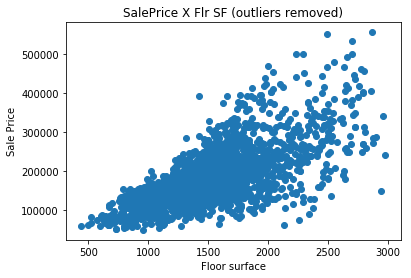

In [295]:
plt.scatter(data_final['Flr SF'],data_final['SalePrice'])
plt.xlabel('Floor surface')
plt.ylabel('Sale Price')
plt.title('SalePrice X Flr SF (outliers removed)')
plt.show()

In [296]:
from sklearn.metrics import r2_score

In [297]:
# start by splitting train and test sets
# Create X, y
X = data_final['Flr SF'].values
y = np.log10(data_final.SalePrice.values)
#y = data_final.SalePrice.values

# Split into train/test sets
# test difference splits
test = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
z1 = []
z2 = []
for t in test:
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, test_size = t, train_size = (1-t), random_state=0)
    
    #print('Train:', X_train.shape, y_train.shape)
    #print('Test:', X_test.shape, y_test.shape)

    # Try with a linear regression
    coef = np.polyfit(X_train_s,y_train_s,deg=1)
    #x_values = np.linspace(x.min(),x.max(),n=100)
    y_pred_test_s = np.polyval(coef,X_test_s)
    #y_base_test = np.median(y_train)

    #print('Train MSE: {:.4f}'.format(MSE(y_train, lr.predict(X_train))),'split:',t)
    #print('Test MSE: {:.4f}'.format(MSE(y_test, lr.predict(X_test))),'test split:',t)
    print('Test_split:',t,' | ', 'MAE: {:.0f}'.format(MAE(10**y_test_s, 10**y_pred_test_s)),' | ',\
          'R2: {:.2f}'.format(r2_score(y_test_s, y_pred_test_s))) # corrected with R2 correct formula
    #print('Test MAE: {:.0f}'.format(MAE(y_test, y_pred_test)))
    z1.append(MAE(10**y_test_s, 10**y_pred_test_s))
    z2.append(np.mean(np.abs(10**y_test_s - np.median(10**y_train_s))))
    #print('R2: {:.2f}'.format(1 - MAE(y_test, y_pred_test)/np.mean(np.abs(y_test - np.median(y_train)))))

Test_split: 0.1  |  MAE: 35818  |  R2: 0.54
Test_split: 0.2  |  MAE: 36400  |  R2: 0.54
Test_split: 0.3  |  MAE: 36631  |  R2: 0.50
Test_split: 0.4  |  MAE: 36703  |  R2: 0.51
Test_split: 0.5  |  MAE: 36803  |  R2: 0.52
Test_split: 0.6  |  MAE: 36497  |  R2: 0.51
Test_split: 0.7  |  MAE: 36296  |  R2: 0.51
Test_split: 0.8  |  MAE: 36401  |  R2: 0.51
Test_split: 0.9  |  MAE: 36241  |  R2: 0.50


Base on findings will go with 0.2 test_split as seems to be an inflection point


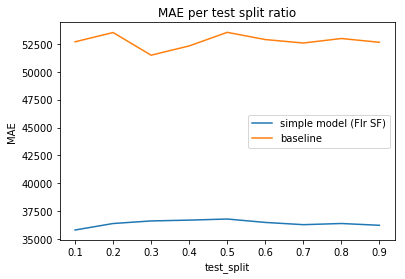

In [298]:
print('Base on findings will go with 0.2 test_split as seems to be an inflection point')
plt.plot(test,z1, label='simple model (Flr SF)')
plt.plot(test,z2, label='baseline')
plt.title('MAE per test split ratio')
plt.ylabel('MAE')
plt.xlabel('test_split')
plt.legend()
plt.show()

In [299]:
mae_simple = round(z1[1],0)
mae_base = round(z2[1],0)
print('Simple model MAE:',mae_simple)
print('Base model MAE:',mae_base)

Simple model MAE: 36400.0
Base model MAE: 53518.0


### (ii) Intermediate model

* Need to do some additional data cleaning on 3 variable which still have 'NaN' which are cresting error when computing model
* Also using list of columns in scope for a more efficient a re-usable (not hardcoded) code

In [300]:
# identifying columns with NULL values
data_final.isnull().sum().to_frame().sort_values(by=0, ascending=False).head()

,0
Order,0
Garage Type_Basment,0
Mas Vnr Type_None,0
Mas Vnr Type_Stone,0
Foundation_CBlock,0


In [301]:
# List of 20 most correlated columns
data_final.corr()[['SalePrice']].drop('SalePrice').sort_values(by="SalePrice",ascending=False).head(20)

,SalePrice
Overall Qual,0.808766
Flr SF,0.708248
Gr Liv Area,0.702660
Kitchen Qual,0.679095
Garage Cars,0.659149
Garage Area,0.652643
Total Bsmt SF,0.652170
Bath,0.628218
Bsmt Qual,0.619200
Garage Finish,0.572745


In [302]:
# Creating list of 20 most correlated columns
print(data_final.corr()[['SalePrice']].drop('SalePrice').sort_values(by="SalePrice",ascending=False).head(20).index.values)
columns_int_model = data_final.corr()[['SalePrice']].drop('SalePrice').sort_values(by="SalePrice",ascending=False).head(20).index.values.tolist()

['Overall Qual' 'Flr SF' 'Gr Liv Area' 'Kitchen Qual' 'Garage Cars'
 'Garage Area' 'Total Bsmt SF' 'Bath' 'Bsmt Qual' 'Garage Finish'
 'Fireplace Qu' 'Foundation_PConc' 'Mas Vnr Area' 'Fireplaces'
 'TotRms AbvGrd' 'Heating QC' 'BsmtFin SF 1' 'Neighborhood_NridgHt'
 'Garage Yr Blt_2010.0' 'Year Built_2010']


In [303]:
# merging both lists
print(data_final.filter(regex='Garage Yr|Garage Type|Year Built|Neighborhood').columns)
columns_int_model.extend(data_final.filter(regex='Garage Yr|Garage Type|Year Built|Neighborhood').columns)

Index(['Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Greens',
       'Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 'Neighborhood_Landmrk',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU',
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker',
       'Garage Type_Attchd', 'Garage Type_Basment', 'Garage Type_BuiltIn',
       'Garage Type_CarPort', 'Garage Type_Detchd', 'Garage Type_No Garage',
       'Year Built_1890', 'Year Built_1900', 'Year Built_1910',
       'Year Built_1920', 'Year Built_1930', 'Year Built_1940',
       'Year Built_

In [304]:
# removing the duplicates
columns_int_model_clean = list(dict.fromkeys(columns_int_model))

In [305]:
data_final[columns_int_model_clean].head()

,Overall Qual,Flr SF,Gr Liv Area,Kitchen Qual,Garage Cars,Garage Area,Total Bsmt SF,Bath,Bsmt Qual,Garage Finish,Fireplace Qu,Foundation_PConc,Mas Vnr Area,Fireplaces,TotRms AbvGrd,Heating QC,BsmtFin SF 1,Neighborhood_NridgHt,Garage Yr Blt_2010.0,Year Built_2010,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_No Garage,Year Built_1890,Year Built_1900,Year Built_1910,Year Built_1920,Year Built_1930,Year Built_1940,Year Built_1950,Year Built_1960,Year Built_1970,Year Built_1980,Year Built_1990,Year Built_2000,Garage Yr Blt_1910.0,Garage Yr Blt_1920.0,Garage Yr Blt_1930.0,Garage Yr Blt_1940.0,Garage Yr Blt_1950.0,Garage Yr Blt_1960.0,Garage Yr Blt_1970.0,Garage Yr Blt_1980.0,Garage Yr Blt_1990.0,Garage Yr Blt_2000.0
0,7,2256,2256,4,2.0,554.0,952.0,2.5,4.0,3.0,3.0,1,0.0,1,8,5,300.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,6,1575,1575,4,2.0,400.0,216.0,1.5,3.0,1.0,4.0,0,522.0,1,5,3,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,4,1092,1092,3,1.0,286.0,546.0,1.5,3.0,1.0,0.0,0,80.0,0,6,2,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,5,1700,1700,4,2.0,447.0,1398.0,2.0,3.0,2.0,4.0,0,0.0,1,6,4,1018.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,7,1889,1889,3,1.0,308.0,925.0,1.5,3.0,1.0,4.0,0,0.0,1,9,3,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [306]:
#data_final[data_final.filter(regex='Garage Yr|Garage Type|Year Built').columns]

In [307]:
# start by splitting train and test sets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

# Create X, y
X = data_final[columns_int_model_clean].values
y = np.log10(data_final.SalePrice).values
#y = data_final.SalePrice.values

# Split into train/test sets
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, y, test_size = 0.2, train_size = 0.8, random_state=0)

#print('Train:', X_train.shape, y_train.shape)
#print('Test:', X_test.shape, y_test.shape)

# Try with a linear regression
lr_int = LinearRegression()
lr_int.fit(X_train_i, y_train_i)

#print('Train MSE: {:.4f}'.format(MSE(y_train, lr.predict(X_train))),'split:',t)
#print('Test MSE: {:.4f}'.format(MSE(y_test, lr.predict(X_test))),'test split:',t)
print('Train MAE: {:.0f}'.format(MAE(10**y_train_i, 10**lr_int.predict(X_train_i))))
print('Test MAE: {:.0f}'.format(MAE(10**y_test_i, 10**lr_int.predict(X_test_i))))

Train MAE: 14399
Test MAE: 14858


In [308]:
mae_intermediate = round(MAE(10**y_test_i, 10**lr_int.predict(X_test_i)),0)
print('Intermediate model MAE:',mae_intermediate)
print('Simple model MAE:',mae_simple)
print('Base model MAE:',mae_base)

Intermediate model MAE: 14858.0
Simple model MAE: 36400.0
Base model MAE: 53518.0


### (iii) Complex model old

In [309]:
data_final.to_csv(r'house-price\data_final_train.csv',index=False)
data_test.to_csv(r'house-price\data_final_test.csv',index=False)
# see 'house-price-complex-model' notebook

In [310]:
# start by splitting train and test sets
from sklearn.model_selection import train_test_split

# Create X, y
X = data_final.drop(['SalePrice','PID','Order'], axis=1).values
y = np.log10(data_final.SalePrice).values

# Split into train/test sets
X_train_c, X_valid_c, y_train_c, y_valid_c = train_test_split(X, y, test_size = 0.2, train_size = 0.8, random_state=0)

print('Train:', X_train_c.shape, y_train_c.shape)
print('Valid:', X_valid_c.shape, y_valid_c.shape)

Train: (1899, 264) (1899,)
Valid: (475, 264) (475,)


In [311]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

# Try with a linear regression
lr = LinearRegression()
lr.fit(X_train_c, y_train_c)

#print('Train MSE: {:.4f}'.format(MSE(y_train, lr.predict(X_train))))
#print('Test MSE: {:.4f}'.format(MSE(y_test, lr.predict(X_test))))
#print('Train MAE: {:.0f}'.format(MAE(y_train_c, lr.predict(X_train_c))))
#print('Test MAE: {:.0f}'.format(MAE(y_test_c, lr.predict(X_test_c))))

# below prints when using log
print('Train MAE (log): {:.0f}'.format(MAE(10**y_train_c, 10**lr.predict(X_train_c))))
print('Valid MAE (log): {:.0f}'.format(MAE(10**y_valid_c, 10**lr.predict(X_valid_c))))

Train MAE (log): 10743
Valid MAE (log): 12943


In [312]:
data_final.drop(['SalePrice','PID','Order'], axis=1).columns[lr.coef_ > 1000000]

Index(['Total Bsmt SF', 'Gr Liv Area'], dtype='object')

In [313]:
# above seems to work when include Orders...probably due to ill-conditioning

In [314]:
mae_complex_lr = round(MAE(10**y_valid_c, 10**lr.predict(X_valid_c)),0)
print('Complex lr model MAE:',mae_complex_lr)
print('Intermediate lr model MAE:',mae_intermediate)
print('Simple lr model MAE:',mae_simple)
print('Base model MAE:',mae_base)

Complex lr model MAE: 12943.0
Intermediate lr model MAE: 14858.0
Simple lr model MAE: 36400.0
Base model MAE: 53518.0


### Lasso regression

In [315]:
# tried with Lasso which is supposed to better optimized MAE function but get to much higher results
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1,max_iter=10000)
lasso.fit(X_train_c, y_train_c)

#print('Train MSE: {:.4f}'.format(MSE(y_train, lr.predict(X_train))))
#print('Test MSE: {:.4f}'.format(MSE(y_test, lr.predict(X_test))))
print('Train Lasso MAE: {:.0f}'.format(MAE(10**y_train_c, 10**lasso.predict(X_train_c))))
print('Valid Lasso MAE: {:.0f}'.format(MAE(10**y_valid_c, 10**lasso.predict(X_valid_c))))

Train Lasso MAE: 25170
Valid Lasso MAE: 25383


### Ridge regression

Let's first create the list of  𝑎𝑙𝑝ℎ𝑎  values and evaluate a ridge regression model for each one. Regularization strength affects the generization error on a log-scale. So we will use  𝑛𝑝.𝑙𝑜𝑔𝑠𝑝𝑎𝑐𝑒(𝑎,𝑏)  to generate sample  𝑎𝑙𝑝ℎ𝑎  values i.e. instead of  𝑛𝑝.𝑙𝑖𝑛𝑠𝑝𝑎𝑐𝑒(𝑎,𝑏)

In [316]:
from sklearn.linear_model import Ridge
# Try with a linear regression
ridge = Ridge(random_state=0)
ridge.fit(X_train_c, y_train_c)

#print('Train MSE: {:.4f}'.format(MSE(y_train, lr.predict(X_train))))
#print('Test MSE: {:.4f}'.format(MSE(y_test, lr.predict(X_test))))
print('Train Ridge MAE: {:.0f}'.format(MAE(10**y_train_c, 10**ridge.predict(X_train_c))))
print('Valid Ridge MAE: {:.0f}'.format(MAE(10**y_valid_c, 10**ridge.predict(X_valid_c))))

Train Ridge MAE: 10899
Valid Ridge MAE: 11655


### Grid search

In [317]:
# standardize data
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_train_rescaled_c = scaler.fit_transform(X_train_c)
X_valid_rescaled_c = scaler.transform(X_valid_c)

C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [318]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error as MAE

# Variable to store the results
gs_results = []

# Grid search
for alpha in np.logspace(-10, 10, num=100):
    # Create and fit ridge regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_rescaled_c, y_train_c)
    
    # Save model and its performance on train/test sets
    gs_results.append({
        'alpha': alpha,
        'train_mse': MSE(y_train_c, ridge.predict(X_train_rescaled_c)),
        'train_mae': MAE(10**y_train_c, 10**ridge.predict(X_train_rescaled_c)),
        'valid_mse': MSE(y_valid_c, ridge.predict(X_valid_rescaled_c)),
        'valid_mae': MAE(10**y_valid_c, 10**ridge.predict(X_valid_rescaled_c)),
    })

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.head()

,alpha,train_mae,train_mse,valid_mae,valid_mse
0,1.000000e-10,10741.957713,0.001477,11932.154684,0.001846
1,1.592283e-10,10741.957713,0.001477,11932.178945,0.001846
2,2.535364e-10,10741.957713,0.001477,11932.140246,0.001846
3,4.037017e-10,10741.957713,0.001477,11932.200145,0.001846
4,6.428073e-10,10741.957713,0.001477,11932.187043,0.001846


### Validation curves

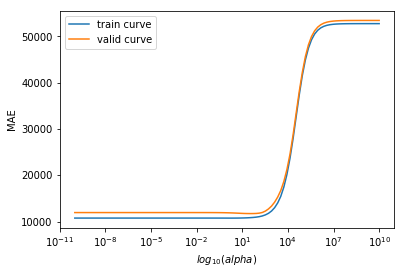

In [319]:
# Plot the validation curves
plt.semilogx(gs_results['alpha'], gs_results['train_mae'], label='train curve')
plt.semilogx(gs_results['alpha'], gs_results['valid_mae'], label='valid curve')
plt.xlabel('$log_{10}(alpha)$')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [320]:
#Let's retrieve the alpha with the best generalization i.e. the one that minimizes the test score.

# Get entry with the best test MSE
best_result = gs_results.loc[gs_results.valid_mse.idxmin()]

# Print the details
print('Best alpha: {:.1e}'.format(best_result.alpha))
print('Test MSE: {:.4f}'.format(best_result.valid_mse))
print('Test MAE: {:,.0f}$'.format(best_result.valid_mae))

Best alpha: 5.2e+01
Test MSE: 0.0017
Test MAE: 11,720$


In [321]:
mae_complex_ridge = round(best_result.valid_mae,0)
print('Complex Ridge model MAE:',mae_complex_ridge)
print('Complex lr model MAE:',mae_complex_lr)
print('Intermediate lr model MAE:',mae_intermediate)
print('Simple lr model MAE:',mae_simple)
print('Base model MAE:',mae_base)

Complex Ridge model MAE: 11720.0
Complex lr model MAE: 12943.0
Intermediate lr model MAE: 14858.0
Simple lr model MAE: 36400.0
Base model MAE: 53518.0


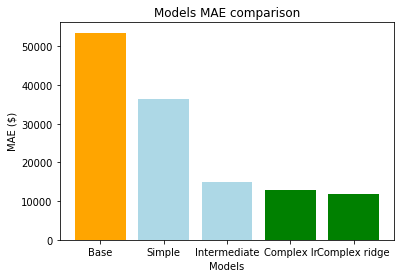

In [322]:
plt.bar(x=['Base','Simple','Intermediate','Complex lr','Complex ridge'],height=[mae_base,mae_simple,mae_intermediate,mae_complex_lr,mae_complex_ridge],color=['orange','lightblue','lightblue','green','green'])
plt.title('Models MAE comparison')
plt.ylabel('MAE ($)')
plt.xlabel('Models')
plt.show()

# Results

### Communicate

Both complex models are over-performing the Base/Simple/Intermdiate models:
* However Intermedia model with 20 variable is already getting pretty decent results with +- 15.5K dollars from house price on average
* Complex models are both perdicting house prices +- 11.6K dollars

Would it make sense to go with the Intermdiate model in this scenario? Based on Occam's razor we shouldn't go for over-complex models if there is not important added value

### Compute

In [323]:
data_test.head()

,Order,PID,Lot Frontage,Lot Area,Utilities,Overall Qual,Overall Cond,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,Low Qual Fin SF,Gr Liv Area,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Val,Condition Count,Bath,Flr SF,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS SubClass_120,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS Zoning_FV,MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Pave,Alley_No access,Alley_Pave,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Norm,Condition 2_PosN,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Matl_Roll,Roof Matl_Tar&Grv,Roof Matl_WdShake,Exterior 1st_BrkFace,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Other,Exterior 2nd_Plywood,Exterior 2nd_Stone,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Central Air_Y,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_No Garage,Misc Feature_Othr,Misc Feature_Shed,Sale Type_CWD,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,New or remod_old,Lot Shape_Reg,Land Slope_Mod,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Paved Drive_P,Paved Drive_Y,Year Built_1880,Year Built_1890,Year Built_1900,Year Built_1910,Year Built_1920,Year Built_1930,Year Built_1940,Year Built_1950,Year Built_1960,Year Built_1970,Year Built_1980,Year Built_1990,Year Built_2000,Year Built_2010,Year Remod/Add_1960.0,Year Remod/Add_1970.0,Year Remod/Add_1980.0,Year Remod/Add_1990.0,Year Remod/Add_2000.0,Year Remod/Add_2010.0,Garage Yr Blt_1910.0,Garage Yr Blt_1920.0,Garage Yr Blt_1930.0,Garage Yr Blt_1940.0,Garage Yr Blt_1950.0,Garage Yr Blt_1960.0,Garage Yr Blt_1970.0,Garage Yr Blt_1980.0,Garage Yr Blt_1990.0,Garage Yr Blt_2000.0,Garage Yr Blt_2010.0,Mo Sold_2,Mo Sold_3,Mo Sold_4,Mo Sold_5,Mo Sold_6,Mo Sold_7,Mo Sold_8,Mo Sold_9,Mo Sold_10,Mo Sold_11,Mo Sold_12,Yr Sold_2007,Yr Sold_2008,Yr Sold_2009,Yr Sold_2010
0,2217,909279080,68.0,9.330343,5,6,7,480.0,3,3,3.0,3.0,2.0,3.0,297.0,2.0,557.0,0.0,854.0,3,0,1991,3,1,3,7,8,1,4.0,1.0,2.0,432.0,3,2,0,0,19

#### Simple Model

In [324]:
X_test_simple = data_test['Flr SF']
data_test['pred_simple'] = np.round(10**np.polyval(coef,X_test_simple),0)

#### Intermediate model

In [325]:
data_test['Neighborhood_Greens'] = 0
data_test['Neighborhood_GrnHill'] = 0
data_test['Neighborhood_Landmrk'] = 0

In [326]:
X_test_int = data_test[columns_int_model_clean].values

In [327]:
data_test['pred_int'] = np.round(10**lr_int.predict(X_test_int),0)
#data_test[['Order','PID','pred_simple','pred_int']].head()

#### Complex Model - Debug

In [328]:
test_df = pd.read_csv('clean_test_data.csv') # clean dataframes extracted from previous section sand shared by Pangiota
train_df = pd.read_csv('clean_train_data.csv') # clean dataframes extracted from previous section sand shared by Pangiota

In [329]:
test_df.shape

(500, 235)

In [330]:
train_df.shape

(2374, 267)

In [331]:
test_df_reindexed = test_df.reindex(columns=train_df.columns, fill_value=0.0)

In [332]:
test_df_reindexed.shape

(500, 267)

In [333]:
X = train_df.drop(columns=['SalePrice','Order','PID']).values
y = np.log10(train_df['SalePrice']).values
X_test = test_df_reindexed.drop(columns=['SalePrice','Order','PID']).values


print('X Train shape:',X.shape)
print('y Train shape:',y.shape)
print('X Test shape:',X_test.shape)

X Train shape: (2374, 264)
y Train shape: (2374,)
X Test shape: (500, 264)


In [334]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

In [335]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

In [336]:
scaler2 = StandardScaler()

X_train_rescaled = scaler2.fit_transform(X_train)
X_valid_rescaled = scaler2.transform(X_valid)
X_test_rescaled = scaler2.transform(X_test)

In [337]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

# Variable to store the results
gs_results = []

# Grid search
for alpha in np.logspace(-4, 4, num=200):
    # Create and fit ridge regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_rescaled, y_train)
    
    # Save model and its performance on train/test sets
    gs_results.append({
        'alpha': alpha,
        'train_mse': MSE(y_train, ridge.predict(X_train_rescaled)),
        'train_mae': MAE(10**y_train, 10**ridge.predict(X_train_rescaled)),
        'valid_mse': MSE(y_valid, ridge.predict(X_valid_rescaled)),
        'valid_mae': MAE(10**y_valid, 10**ridge.predict(X_valid_rescaled)),
    })

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.head()

,alpha,train_mae,train_mse,valid_mae,valid_mse
0,0.000100,10605.021905,0.001412,12683.397634,0.002269
1,0.000110,10605.021888,0.001412,12683.396949,0.002269
2,0.000120,10605.021869,0.001412,12683.396198,0.002269
3,0.000132,10605.021849,0.001412,12683.395373,0.002269
4,0.000145,10605.021827,0.001412,12683.394469,0.002269


In [338]:
test_df.isnull().sum().sum()

0

In [339]:
train_df.isnull().sum().sum()

0

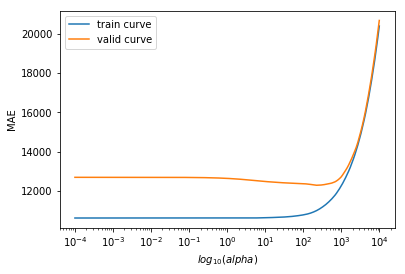

In [340]:
import matplotlib.pyplot as plt
# Plot the validation curves
plt.semilogx(gs_results['alpha'], gs_results['train_mae'], label='train curve')
plt.semilogx(gs_results['alpha'], gs_results['valid_mae'], label='valid curve')
plt.xlabel('$log_{10}(alpha)$')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [364]:
gs_results.sort_values(by='valid_mae').head()

,alpha,train_mae,train_mse,valid_mae,valid_mse
158,224.780583,10983.598501,0.001525,12278.345856,0.002129
159,246.581108,11025.746773,0.001535,12281.982013,0.002132
157,204.907469,10946.347628,0.001516,12283.661250,0.002128
160,270.495973,11071.029406,0.001545,12285.464400,0.002134
161,296.730241,11121.629120,0.001557,12290.398183,0.002138


In [342]:
#Let's retrieve the alpha with the best generalization i.e. the one that minimizes the test score.
# Get entry with the best test MSE
best_result = gs_results.loc[gs_results.valid_mse.idxmin()]

# Print the details
print('Best alpha: {:.1e}'.format(best_result.alpha))
print('Valid MSE: {:.4f}'.format(best_result.valid_mse))
print('Valid MAE: {:,.0f}$'.format(best_result.valid_mae))

Best alpha: 1.7e+02
Valid MSE: 0.0021
Valid MAE: 12,310$


In [343]:
ridge2 = Ridge(best_result.alpha)
ridge2.fit(X_train_rescaled, y_train)

print('Best alpha:',best_result.alpha)
print('Train Ridge MAE: {:.0f}'.format(MAE(10**y_train, 10**ridge2.predict(X_train_rescaled))))
print('Test Ridge MAE: {:.0f}'.format(MAE(10**y_valid, 10**ridge2.predict(X_valid_rescaled))))

Best alpha: 170.27691722259013
Train Ridge MAE: 10882
Test Ridge MAE: 12310


In [344]:
#df_test['pred_complex'] = np.round(10**ridge4.predict(X_test_rescaled),0)
test_df['pred_complex'] = 10**ridge2.predict(X_test_rescaled)

In [345]:
test_df[['PID','pred_complex']].head()

,PID,pred_complex
0,909279080,189735.135534
1,907126050,143776.653221
2,528144030,280168.101975
3,535452060,120445.035829
4,911202100,108059.739311


In [346]:
#data_test[['PID','pred_simple','pred_int','pred_complex']].head(10)
test_df[['PID','pred_complex']].rename(columns={'pred_complex':'SalePrice'}).to_csv(r'house-price\predictions-complex-model.csv',index=False)

#### Complex Old - to be removed

In [347]:
print('Shape test:',data_test.shape)
print('Shape final:',data_final.shape)

Shape test: (500, 240)
Shape final: (2374, 267)


In [348]:
data_final.head()

,Order,PID,Lot Frontage,Lot Area,Utilities,Overall Qual,Overall Cond,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,Low Qual Fin SF,Gr Liv Area,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Val,SalePrice,Condition Count,Bath,Flr SF,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS SubClass_120,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Pave,Alley_No access,Alley_Pave,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Metal,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exterior 1st_AsphShn,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CBlock,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_ImStucc,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_PreCast,Exterior 1st_Stone,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_AsphShn,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_PreCast,Exterior 2nd_Stone,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Mas Vnr Type_BrkFace,Mas Vnr Type_CBlock,Mas Vnr Type_None,Mas Vnr Type_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Central Air_Y,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_No Garage,Misc Feature_Gar2,Misc Feature_None,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,New or remod_old,Lot Shape_Reg,Land Slope_Mod,Land Slope_Sev,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Paved Drive_P,Paved Drive_Y,Year Built_1890,Year Built_1900,Year Built_1910,Year Built_1920,Year Built_1930,Year Built_1940,Year Built_1950,Year Built_1960,Year Built_1970,Year Built_1980,Year Built_1990,Year Built_2000,Year Built_2010,Year Remod/Add_1960.0,Year Remod/Add_1970.0,Year Remod/Add_1980.0,Year Remod/Add_1990.0,Year R

In [349]:
test_list = data_test.drop(columns=['pred_simple','pred_int','Order','PID']).columns.tolist()
train_list = data_final.drop(columns=['SalePrice','Order','PID']).columns.tolist()

In [350]:
# remove columns which are in test list but not in initial data used to fit LinearRegression
to_drop = []
for x in test_list:
    if x in train_list: continue
    else:
        print(x)
        to_drop.append(x)
data_test.drop(columns=to_drop,inplace=True)

Roof Matl_Roll
Exterior 2nd_Other
Year Built_1880


In [351]:
# add variables which are in data used to fit LinearRegression but not in test sample
for x in train_list:
    if x in test_list: continue
    else:
        print(x)
        data_test[x] = 0

MS SubClass_150
MS Zoning_C (all)
MS Zoning_I (all)
Condition 2_Feedr
Condition 2_PosA
Condition 2_RRAe
Condition 2_RRAn
Condition 2_RRNn
Roof Matl_CompShg
Roof Matl_Membran
Roof Matl_Metal
Roof Matl_WdShngl
Exterior 1st_AsphShn
Exterior 1st_BrkComm
Exterior 1st_CBlock
Exterior 1st_ImStucc
Exterior 1st_PreCast
Exterior 1st_Stone
Exterior 2nd_AsphShn
Exterior 2nd_PreCast
Mas Vnr Type_CBlock
Foundation_Wood
Heating_GasA
Misc Feature_Gar2
Misc Feature_None
Misc Feature_TenC
Sale Type_Con
Sale Type_VWD
Roof Style_Shed
Land Slope_Sev
Electrical_Mix


In [352]:
print('Shape test:',data_test.shape)
print('Shape final:',data_final.shape)

Shape test: (500, 268)
Shape final: (2374, 267)


In [353]:
data_test.drop(columns=['pred_simple','pred_int','Order','PID']).columns

Index(['Lot Frontage', 'Lot Area', 'Utilities', 'Overall Qual', 'Overall Cond',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
       ...
       'Foundation_Wood', 'Heating_GasA', 'Misc Feature_Gar2',
       'Misc Feature_None', 'Misc Feature_TenC', 'Sale Type_Con',
       'Sale Type_VWD', 'Roof Style_Shed', 'Land Slope_Sev', 'Electrical_Mix'],
      dtype='object', length=264)

In [354]:
data_final.drop(['SalePrice','PID','Order'], axis=1).columns

Index(['Lot Frontage', 'Lot Area', 'Utilities', 'Overall Qual', 'Overall Cond',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
       ...
       'Mo Sold_7', 'Mo Sold_8', 'Mo Sold_9', 'Mo Sold_10', 'Mo Sold_11',
       'Mo Sold_12', 'Yr Sold_2007', 'Yr Sold_2008', 'Yr Sold_2009',
       'Yr Sold_2010'],
      dtype='object', length=264)

In [355]:
data_test[data_final.drop(['SalePrice','PID','Order'], axis=1).columns].head()

,Lot Frontage,Lot Area,Utilities,Overall Qual,Overall Cond,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,Low Qual Fin SF,Gr Liv Area,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Val,Condition Count,Bath,Flr SF,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS SubClass_120,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Pave,Alley_No access,Alley_Pave,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Metal,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exterior 1st_AsphShn,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CBlock,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_ImStucc,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_PreCast,Exterior 1st_Stone,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_AsphShn,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_PreCast,Exterior 2nd_Stone,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Mas Vnr Type_BrkFace,Mas Vnr Type_CBlock,Mas Vnr Type_None,Mas Vnr Type_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Central Air_Y,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_No Garage,Misc Feature_Gar2,Misc Feature_None,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,New or remod_old,Lot Shape_Reg,Land Slope_Mod,Land Slope_Sev,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Paved Drive_P,Paved Drive_Y,Year Built_1890,Year Built_1900,Year Built_1910,Year Built_1920,Year Built_1930,Year Built_1940,Year Built_1950,Year Built_1960,Year Built_1970,Year Built_1980,Year Built_1990,Year Built_2000,Year Built_2010,Year Remod/Add_1960.0,Year Remod/Add_1970.0,Year Remod/Add_1980.0,Year Remod/Add_1990.0,Year Remod/Add_2000.0,Year

In [356]:
y_train_c.shape

(1899,)

In [357]:
ridge3 = Ridge(alpha=52, random_state=0)
ridge3.fit(X_train_rescaled_c, y_train_c)

print('Train Ridge MAE: {:.0f}'.format(MAE(10**y_train_c, 10**ridge3.predict(X_train_rescaled_c))))
print('Valid Ridge MAE: {:.0f}'.format(MAE(10**y_valid_c, 10**ridge3.predict(X_valid_rescaled_c))))

Train Ridge MAE: 10876
Valid Ridge MAE: 11720


In [358]:
data_test.head()

,Order,PID,Lot Frontage,Lot Area,Utilities,Overall Qual,Overall Cond,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,Low Qual Fin SF,Gr Liv Area,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Val,Condition Count,Bath,Flr SF,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS SubClass_120,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS Zoning_FV,MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Pave,Alley_No access,Alley_Pave,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Norm,Condition 2_PosN,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Matl_Tar&Grv,Roof Matl_WdShake,Exterior 1st_BrkFace,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_Stone,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Central Air_Y,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_No Garage,Misc Feature_Othr,Misc Feature_Shed,Sale Type_CWD,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,New or remod_old,Lot Shape_Reg,Land Slope_Mod,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Paved Drive_P,Paved Drive_Y,Year Built_1890,Year Built_1900,Year Built_1910,Year Built_1920,Year Built_1930,Year Built_1940,Year Built_1950,Year Built_1960,Year Built_1970,Year Built_1980,Year Built_1990,Year Built_2000,Year Built_2010,Year Remod/Add_1960.0,Year Remod/Add_1970.0,Year Remod/Add_1980.0,Year Remod/Add_1990.0,Year Remod/Add_2000.0,Year Remod/Add_2010.0,Garage Yr Blt_1910.0,Garage Yr Blt_1920.0,Garage Yr Blt_1930.0,Garage Yr Blt_1940.0,Garage Yr Blt_1950.0,Garage Yr Blt_1960.0,Garage Yr Blt_1970.0,Garage Yr Blt_1980.0,Garage Yr Blt_1990.0,Garage Yr Blt_2000.0,Garage Yr Blt_2010.0,Mo Sold_2,Mo Sold_3,Mo Sold_4,Mo Sold_5,Mo Sold_6,Mo Sold_7,Mo Sold_8,Mo Sold_9,Mo Sold_10,Mo Sold_11,Mo Sold_12,Yr Sold_2007,Yr Sold_2008,Yr Sold_2009,Yr Sold_2010,pred_simple,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_Landmrk,pred_int,MS SubClass_150,MS Zoning_C (all),MS Zoning_I (all),Condition 2_Feedr,Condition 2_PosA,Condition 2_RRAe,C

In [359]:
#X_test_complex = data_test[data_final.drop(['SalePrice','PID','Order'], axis=1).columns].values
#X_test_complex = data_test.drop(['SalePrice','pred_simple','pred_int'], axis=1).values
X_test_complex = data_test.drop(['pred_simple','pred_int','PID','Order'], axis=1).values
X_test_complex_rescaled = scaler.transform(X_test_complex)

C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [360]:
data_test['pred_complex'] = np.round(10**ridge3.predict(X_test_complex_rescaled),0)

In [361]:
ridge3.score(X_valid_rescaled_c,y_valid_c)

0.9379191986358189

In [362]:
data_test[['PID','pred_simple']].rename(columns={'pred_simple':'SalePrice'}).to_csv(r'house-price\predictions-simple-model.csv',index=False)
data_test[['PID','pred_int']].rename(columns={'pred_int':'SalePrice'}).to_csv(r'house-price\predictions-intermediate-model.csv',index=False)
#data_test[['PID','pred_complex']].rename(columns={'pred_complex':'SalePrice'}).to_csv(r'house-price\predictions-complex-model.csv',index=False)
data_test[['PID','pred_simple','pred_int','pred_complex']].to_csv(r'house-price\predictions-all-model.csv',index=False)

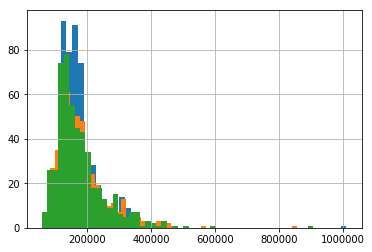

In [363]:
data_test['pred_simple'].hist(bins=50)
data_test['pred_int'].hist(bins=50)
#data_test['pred_complex'].hist(bins=50)
test_df['pred_complex'].hist(bins=50)
plt.show()